# Import packages

In [1]:
%load_ext autoreload
%autoreload 1

In [3]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize()

import numpy as np
import sys 
sys.path.append("/mnt/d/projects/diachronic-p2v/") 

%aimport preprocessing
%aimport utils
%aimport p2v

from utils import prinT
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)

In [5]:
k_list = [10, 10, 10, 10, 10, 10, 10]
start_year_list = ['1950', '1960', '1970', '1980', '1990', '2000', '2010']
end_year_list = ['1959', '1969', '1979', '1989', '1999', '2009', '2021']

# Functions for processing time series

In [6]:
def filter_nan_in_middle(x):
    val_list = x.to_list()
    
    start_idx = -1
    end_idx = -1
    nan_in_middle = False
    for i in range(0, len(val_list)):
        if not np.isnan(val_list[i]):
            start_idx = i
            break
    for i in range(len(val_list)-1, -1, -1):
        if not np.isnan(val_list[i]):
            end_idx = i
            break
    for i in range(start_idx, end_idx):
        if np.isnan(val_list[i]):
            nan_in_middle = True
            break
    if start_idx == end_idx:
        len_of_1 = True
    else :
        len_of_1 = False
    return nan_in_middle, len_of_1, start_idx, end_idx

# Generate a dataframe which contains periodical's local semantic change

In [5]:
from sklearn.metrics.pairwise import cosine_similarity, paired_distances

def cal_local_distance(x, tar_neighbor_idxs, ref_neighbor_idxs, tar_vectors, ref_vectors):
    neighbor_idx_list = list(set(tar_neighbor_idxs[x]).union(set(ref_neighbor_idxs[x])))
    tar_neighbor_vectors = [tar_vectors[idx] for idx in neighbor_idx_list]
    ref_neighbor_vectors = [ref_vectors[idx] for idx in neighbor_idx_list]
    tar_focal_vector = tar_vectors[x]
    ref_focal_vector = ref_vectors[x]

    tar_second_order_change = cosine_similarity(tar_focal_vector.reshape(1,-1), tar_neighbor_vectors)
    ref_second_order_change = cosine_similarity(ref_focal_vector.reshape(1,-1), ref_neighbor_vectors)

    return paired_distances(tar_second_order_change, ref_second_order_change, metric='cosine')[0]

In [6]:
model = p2v.P2V()

local_semantic_change_df = pd.DataFrame(columns=['VID'])
col_name_list = ['semantic_change_1960s', 
                 'semantic_change_1970s', 
                 'semantic_change_1980s',
                 'semantic_change_1990s',
                 'semantic_change_2000s',
                 'semantic_change_2010s']

for i in range(0, 6):
    old_start_year, old_end_year = start_year_list[i], end_year_list[i]
    new_start_year, new_end_year = start_year_list[i+1], end_year_list[i+1]
    print("-----------------------")
    prinT("start comparing {}-{} with the {}-{}".format(old_start_year, old_end_year, new_start_year, new_end_year))

    old_wv = model.load_wv(old_start_year, old_end_year, 100, 10)
    new_wv = model.load_wv(new_start_year, new_end_year, 100, 10)
    
    old_VIDs = old_wv.index_to_key
    new_VIDs = new_wv.index_to_key
    shared_VIDs = list(set(old_VIDs) & set(new_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))
    
    old_idx = [old_wv.get_index(VID) for VID in shared_VIDs]
    new_idx = [new_wv.get_index(VID) for VID in shared_VIDs]
    
    old_vectors = old_wv.get_normed_vectors()[old_idx]
    new_vectors = new_wv.get_normed_vectors()[new_idx]

    prinT("finish, start generate neighbor union...")
    old_neighbor_idxs = np.argsort(cosine_similarity(old_vectors, old_vectors))[:, -2:-k_list[i]-2:-1]
    new_neighbor_idxs = np.argsort(cosine_similarity(new_vectors, new_vectors))[:, -2:-k_list[i+1]-2:-1]
    
    prinT("start cal local neighbor distance...")
    dist_df = pd.DataFrame({'VID': shared_VIDs})
    statistic = dist_df.index.to_series().parallel_apply(cal_local_distance, args=(old_neighbor_idxs, 
                                                                              new_neighbor_idxs, 
                                                                              old_vectors, 
                                                                              new_vectors))
    prinT("finish")

    dist_df[col_name_list[i]] = statistic
    local_semantic_change_df = local_semantic_change_df.merge(dist_df, on='VID', how='outer')
    local_semantic_change_df['total_semantic_change_'+new_start_year+'s'] = local_semantic_change_df[col_name_list[0:i+1]].sum(axis=1)

2024-04-26 21:06:24 -- start loading Mag_venue_info_df
2024-04-26 21:06:24 -- finish.
2024-04-26 21:06:24 -- start loading labeled_journal_info_df
2024-04-26 21:06:24 -- finish.
-----------------------
2024-04-26 21:06:24 -- start comparing 1950-1959 with the 1960-1969
2024-04-26 21:06:24 -- start loading word vectors...
2024-04-26 21:06:24 -- word vectors loaded, and its shape is: (1645, 100)
2024-04-26 21:06:24 -- start loading word vectors...
2024-04-26 21:06:24 -- word vectors loaded, and its shape is: (3116, 100)
2024-04-26 21:06:24 -- the number of shared VIDs between this two decades: 1500
2024-04-26 21:06:24 -- finish, start generate neighbor union...
2024-04-26 21:06:24 -- start cal local neighbor distance...
2024-04-26 21:06:25 -- finish
-----------------------
2024-04-26 21:06:25 -- start comparing 1960-1969 with the 1970-1979
2024-04-26 21:06:25 -- start loading word vectors...
2024-04-26 21:06:25 -- word vectors loaded, and its shape is: (3116, 100)
2024-04-26 21:06:25 -- 

In [7]:
# Labelling
local_semantic_change_df.loc[:,'venue_name'] = local_semantic_change_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
# Using the lastes decade's labels
VID_labele_dict = model.load_VID_labeled(2010, 2021, 100, 10)
local_semantic_change_df['scopus_label'] = local_semantic_change_df.VID.map(lambda x: VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                                                            else np.nan)

2024-04-26 21:07:33 -- start loading VID_labeled...
2024-04-26 21:07:33 -- finish.


In [8]:
# incorrect venues in MAG
corrupted_venue_name_list = ['Japanese Journal of Pharmacology', 
                             'Journal of Computers',
                             'Journal of Algorithms',
                             'Journal of Agricultural Engineering Research',
                             'Sozial-und Praventivmedizin',
                             'Scientia Forestalis',
                             'Interpretation',
                             'Genes',
                             'Protein Science',
                             'Hospital Medicine',
                             'Immunotechnology',
                             'Journal of Ayurveda and Integrative Medicine',
                             'Versus',
                             'Tradition',
                             'ACM Transactions on Cyber-Physical Systems',
                             'Journal of Biomedical Engineering',
                             'Antibiotics and Chemotherapy',
                             'Social Work',
                             'Production Journal',
                             'Insight',
                             'Sats',
                             'English',
                             'Leonardo',
                             'The Forum',
                             'Chemical Industry',
                             'The American review of respiratory disease',
                             'Chemistry & Industry',
                             'Lawrence Berkeley National Laboratory',
                             'international symposium on open collaboration',
                             'Scopus',
                             'Technical reports',
                             'The annual research report',
                             'Biosilico',
                             '0',
                             'Computer Science and Its Applications',
                             'Journal of Programming Languages',
                             'Fuel and Energy Abstracts',
                            ]

In [9]:
# Filtering
local_semantic_change_df = local_semantic_change_df[~(local_semantic_change_df.venue_name.isin(corrupted_venue_name_list))]
local_semantic_change_df[['nan_in_middle', 
                          'len_of_1', 
                          'start_idx', 
                          'end_idx']] = local_semantic_change_df[col_name_list].apply(filter_nan_in_middle, axis=1, result_type='expand')
# Make sure that each time series never interrupts and has a value for the lastest decade
local_semantic_change_df = local_semantic_change_df[(local_semantic_change_df.nan_in_middle==False) & (local_semantic_change_df.end_idx==5)]

In [10]:
# save as .pkl file
local_semantic_change_df.to_pickle('local_semantic_change_k_10.pkl')

# Load the pre-generated DataFrame from the local file

In [8]:
model = p2v.P2V()
local_semantic_change_df = pd.read_pickle('/mnt/d/projects/diachronic-p2v/figures/semantic_change/local_semantic_change_k_10.pkl')

data_dir:  /mnt/d/projects/diachronic-p2v/data
2025-01-05 17:13:52 -- start loading Mag_venue_info_df
2025-01-05 17:13:52 -- finish.
2025-01-05 17:13:52 -- start loading labeled_journal_info_df
2025-01-05 17:13:52 -- finish.


# Descriptive plots

## Plot single periodical's local semantic change in every decade

In [27]:
abbr_dict = {
    'Proceedings of The Royal Society B: Biological Sciences': 'PRSB',
    'Philosophical Transactions of the Royal Society B': 'PTRSB',
    'Yale Journal of Biology and Medicine': 'Yale J. Biol. Med.',

    'Bulletin of Mathematical Biology': 'Bull. Math. Biol.',
    'meeting of the association for computational linguistics': 'ACL',
    'Journal of the Acoustical Society of America': 'J. Acoust. Soc. Am.',

    'Quarterly Journal of Economics': 'QJE', 
    'Annals of Mathematics':'Ann. Math.',
    'American Sociological Review': 'ASR',
    }

/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)
/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)
/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)
/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)
/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-

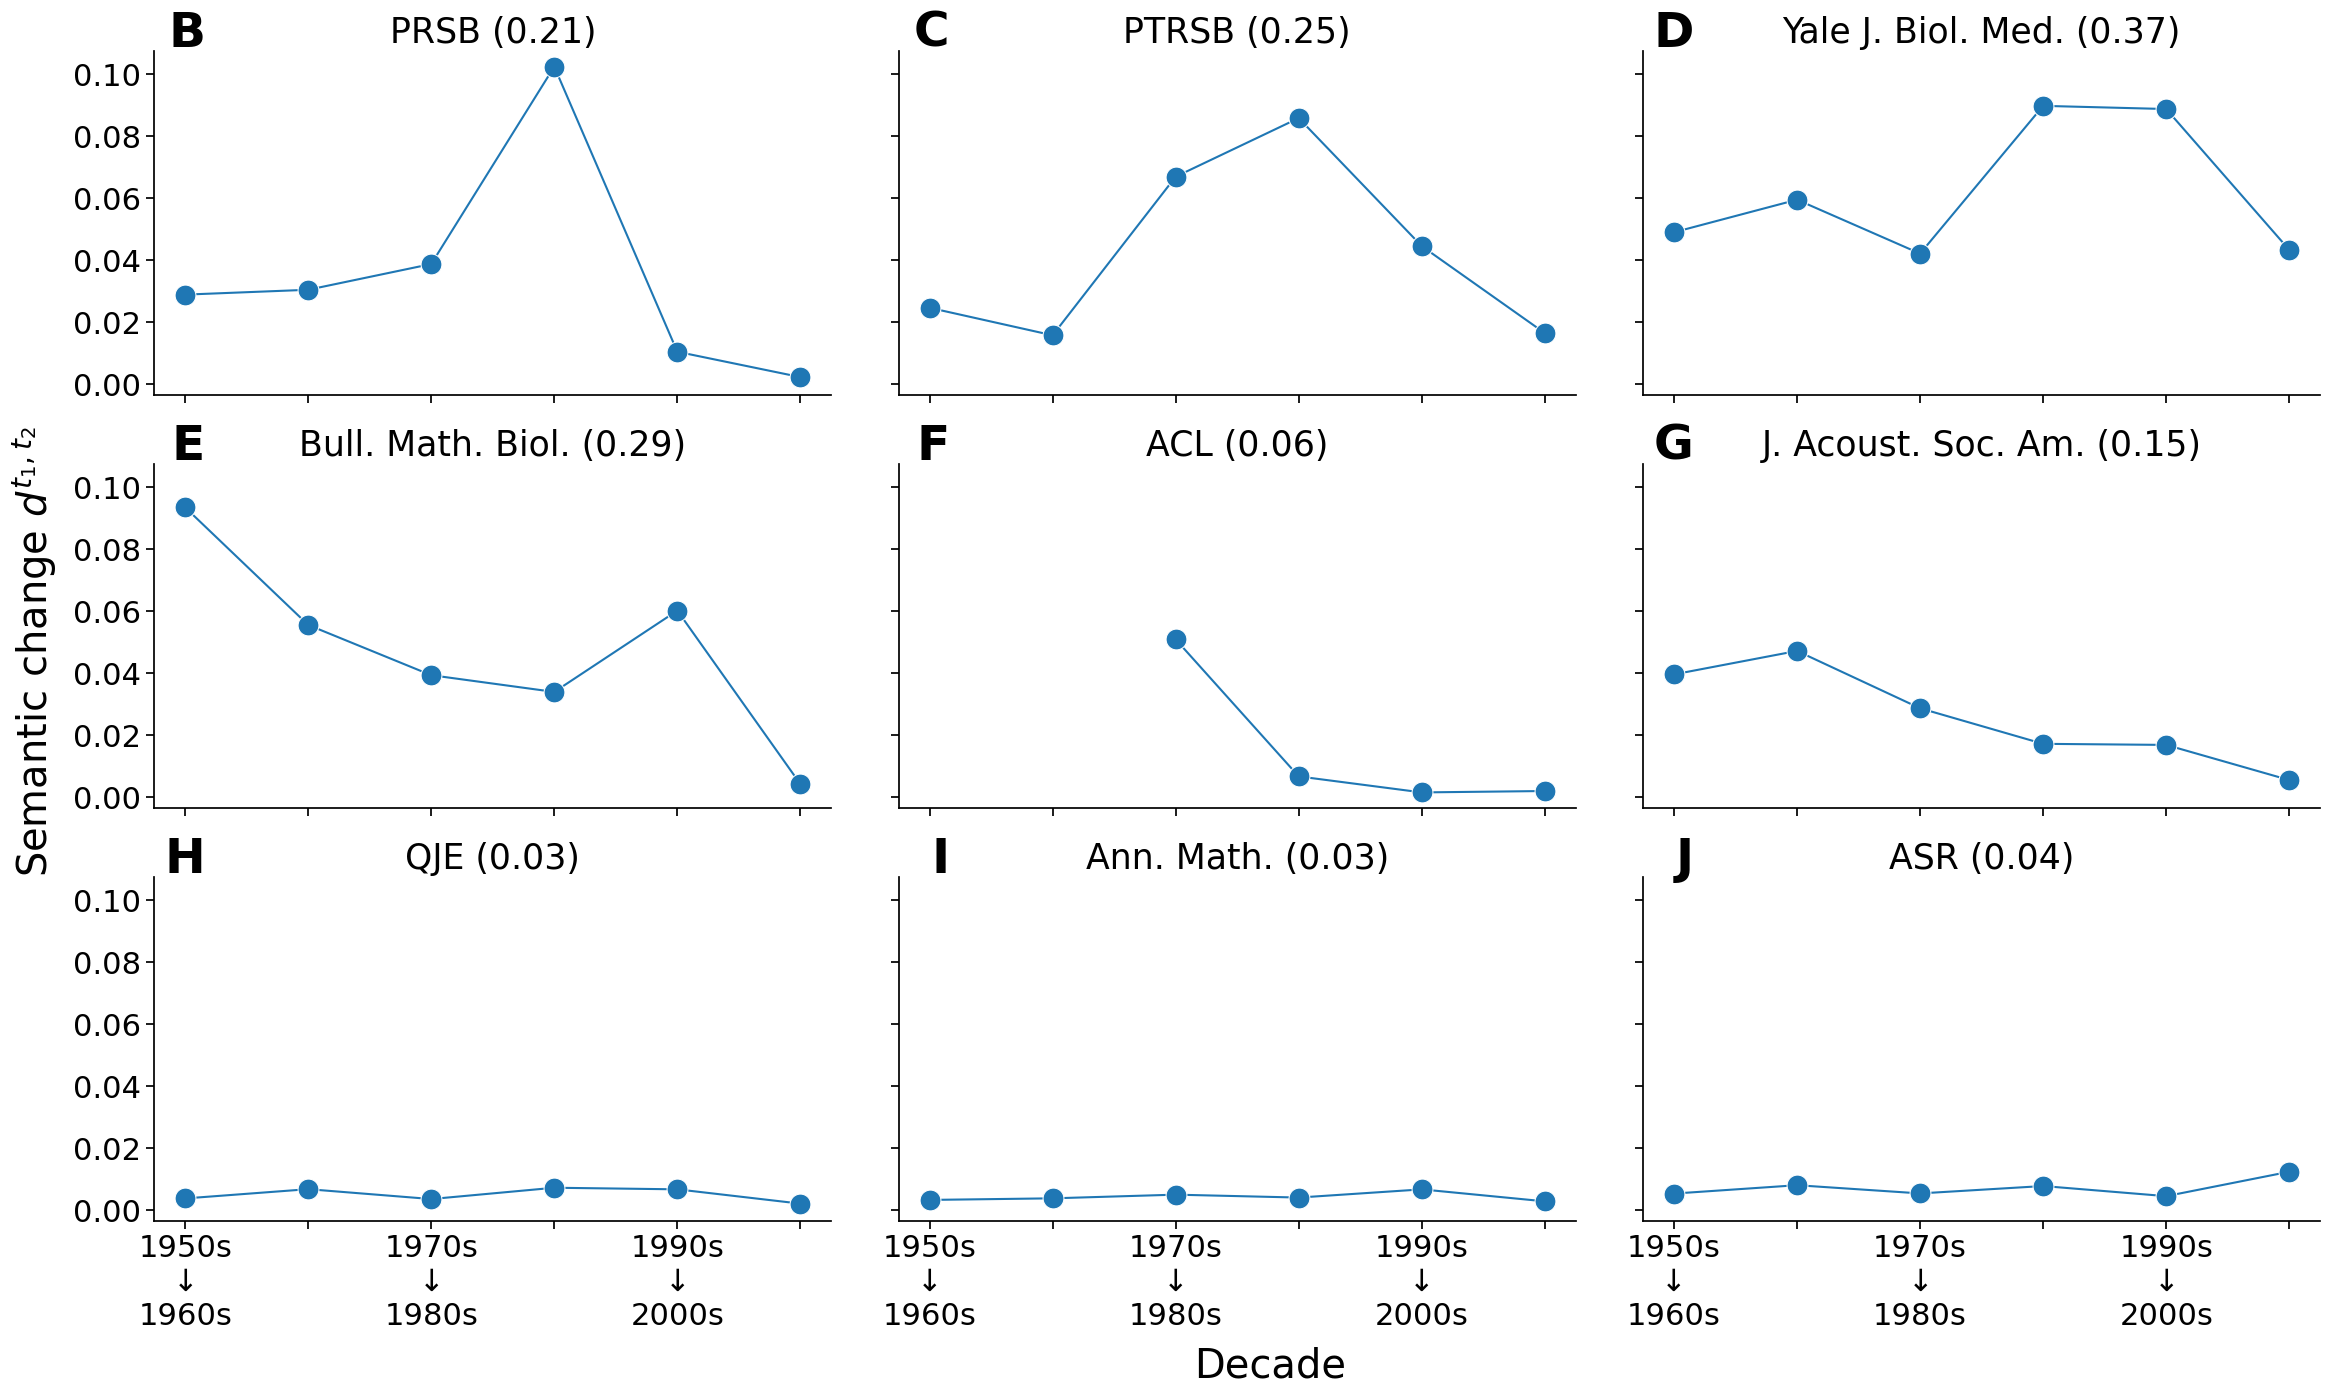

In [43]:
local_semantic_change_df_rename = local_semantic_change_df[local_semantic_change_df.venue_name.isin(abbr_dict.keys())].copy()
local_semantic_change_df_rename.venue_name = local_semantic_change_df_rename.venue_name.replace(abbr_dict)

local_semantic_change_df_wide = pd.wide_to_long(local_semantic_change_df_rename,
                                                stubnames=['semantic_change'],
                                                suffix='.+',
                                                sep='_',
                                                i = ['venue_name'],
                                                j = 'decade')

with sns.plotting_context("notebook", font_scale=2):
    g1 = sns.relplot(data=local_semantic_change_df_wide,
                    x='decade', y='semantic_change',
                    legend=False,
                    col='venue_name', col_order=abbr_dict.values(), col_wrap=3, aspect=1.75, 
                    kind='line', marker='o', markersize=15)
    g1.set(xticklabels=['1950s\n↓\n1960s', '1960s\n↓\n1970s','1970s\n↓\n1980s','1980s\n↓\n1990s','1990s\n↓\n2000s','2000s\n↓\n2010s',])

    # Generate titles (abbr+(change value))
    title_list = []
    for abbr in abbr_dict.values():
        total_change = local_semantic_change_df_rename[local_semantic_change_df_rename.venue_name == abbr].total_semantic_change_2010s.values[0]
        title_list.append(abbr + ' ('+ f"{total_change:.{2}f}" + ')')
        
    pannel_labels = list("BCDEFGHIJ")
    for i in range(len(g1.axes.flat)):
        ax = g1.axes.flat[i]

        # Only show a half of xlabels
        labels = ax.get_xticklabels()
        for j, label in enumerate(labels):
            if j % 2 != 0:
                label.set_visible(False)

        # Plot pannel labels
        ax.text(0.075, 1.12, pannel_labels[i], transform=ax.transAxes, 
                fontsize=35, fontweight='bold', va='top', ha='right')

        ax.set_title(title_list[i], fontsize=25) 
        
    g1.set_ylabels('')
    g1.set_xlabels('')
    g1.figure.supylabel(r'Semantic change $d^{t_1,t_2}$')
    g1.figure.supxlabel('Decade')
    g1.figure.subplots_adjust(left=0.075, right=0.9, top=0.9, bottom=0.12, wspace=0.1, hspace=0.2)

plt.show()

In [44]:
g1.savefig('/mnt/d/projects/diachronic-p2v/figures/semantic_change/single_periodical_local_semantic_change_k_10.pdf',
          facecolor='white', 
          transparent=False, 
          bbox_inches='tight')

## Plot the distribution of periodicals' total semantic change

In [14]:
abbr_dict = {# 1950s
             'CA: A Cancer Journal for Clinicians':'CA: Cancer J. Clin.',
             'Quarterly Journal of Economics': 'QJE', 
             'Econometrica': 'Econometrica', 
             'Psychological Bulletin': 'Psychol. Bull.',
             'Chemical Reviews': 'Chem. Rev.',
             'JAMA': 'JAMA',
             'Science': 'Science',
             'Nature': 'Nature',
             'Proceedings of the National Academy of Sciences of the United States of America': 'PNAS',
             'Physical Review Letters': 'PRL',
             'The New England Journal of Medicine': 'NEJM',
             'American Sociological Review': 'ASR',
             'Annals of Mathematics':'Ann. Math.',
             'The Lancet': 'Lancet',
             'BMJ': 'BMJ',
             'Proceedings of The Royal Society B: Biological Sciences': 'Proc. R. Soc. B',
    
             # 1960s
             'Atmosphere':'Atmosphere',
             'Language Learning': 'Lang. Learn.',
             'Automatica': 'Automatica',
             'Materials Research Bulletin': 'Mater. Res. Bull.',
             'Carbon':'Carbon',
             'Stanford Law Review': 'SLR',
             'Computing': 'Computing',
             'Journal of Applied Crystallography': 'J. Appl. Crystallogr.',
             'Ultrasonics': 'Ultrasonics',
             'IEEE Transactions on Nuclear Science': 'IEEE Trans Nucl Sci',
             'IEEE Transactions on Biomedical Engineering': 'IEEE. Trans. Biomed. Eng.',
             'Pattern Recognition': 'Pattern Recognit.',
             'Physics Letters B': 'PLB',
             'Journal of Financial and Quantitative Analysis': 'JFQA',
                
             # 1970s
             'Studies in Second Language Acquisition':'Stud. Second Lang. Acquis.',
             'Linguistic Inquiry': 'Linguist. Inq.',
             'European Journal of Political Research': 'EJPR',
             'Accounting Organizations and Society': 'Account. Organ. Soc.',
             'Clinical Infectious Diseases': 'Clin. Infect. Dis.',
             'Economic Analysis and Policy': 'Econ Anal Policy',
             'Research Policy': 'Res. Policy',
             'Gene': 'Gene',
             'Pain': 'Pain',
             'Social Networks': 'Soc. Netw.',
             'Life sciences in space research': 'Life Sci Space Res',
             'Computational Biology and Chemistry': 'Comput Biol Chem',
             'Civil Engineering': 'C.E.J',
             'Journal of Biosciences': 'J. Biosci.',
             'Cell': 'Cell',
    
             # 1980s
             'Applied Linguistics':'Appl. Linguist.',
             'Journal of Accounting and Economics': 'J. Account. Econ.',
             'Journal of Accounting and Public Policy': 'JAPP',
             'Journal of Physics: Condensed Matter': 'J. Phys. Condens. Matter',
             'Transport Reviews': 'Transp. Rev.',
             'European Management Journal': 'EMJ',
             'International Journal of Remote Sensing': 'Int. J. Remote Sens.',
             'Stem Cells': 'Stem Cells',
             'Journal of Chemometrics': 'J. Chemom.',
             'Bioelectromagnetics': 'Bioelectromagnetics',
             'neural information processing systems': 'NeurIPS',
             'IEEE Transactions on Medical Imaging': 'IEEE TMI',

             # 1990s
             'The Accounting Review': 'Account. Rev.',
             'Human Resource Management Journal': 'Hum. Resour. Manag. J.',
             'Cancer Cell': 'Cancer Cell',
             'IEEE Transactions on Applied Superconductivity': 'IEEE TAS',
             'Cell Research': 'Cell Res.',
             'the web conference': 'TheWebConf',
             'knowledge discovery and data mining': 'KDD',
             'empirical methods in natural language processing': 'EMNLP',
             'Materials': 'Materials',
             'Sensors': 'Sensor',
             'Complexity': 'Complexity',

             # 2000s
             'PLOS ONE': 'PLOS ONE',
             'Nature Reviews Immunology': 'Nat. Rev. Immunol.',
             'Nature Materials': 'Nat. Mater',
             'Lancet Oncology': 'Lancet Oncol.',
             'Nature Photonics': 'Nat. Photonics',
             'Obesity': 'Obesity',
             'Nature Chemical Biology': 'Nat. Chem. Biol.',
             'IEEE Transactions on Industrial Informatics': 'IEEE TII',
             'BMC Research Notes': 'BMC Res. Notes',
            }

display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==0)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==1)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==2)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==3)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==4)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))
display(local_semantic_change_df[(local_semantic_change_df.venue_name.isin(abbr_dict.keys()))&(local_semantic_change_df.start_idx==5)][['venue_name', 'total_semantic_change_2010s']].sort_values(by='total_semantic_change_2010s', ascending=False))

venue_name  \
979                                                                           Science   
85                                                                             Nature   
1091                          Proceedings of The Royal Society B: Biological Sciences   
1320  Proceedings of the National Academy of Sciences of the United States of America   
565                                               CA: A Cancer Journal for Clinicians   
852                                                                        The Lancet   
1330                                                                              BMJ   
193                                                                              JAMA   
511                                                                  Chemical Reviews   
1325                                                           Psychological Bulletin   
857                                               The New England Journal of Medicine   
442                                                           Physical Review Letters   
1117                                                     American Sociological Review   
605                                                                      Econometrica   
374                                                    Quarterly Journal of Economics   
497                                                             Annals of Mathematics   

      total_semantic_change_2010s  
979                      0.287024  
85                       0.236174  
1091                     0.213366  
1320                     0.118479  
565                      0.101693  
852                      0.081893  
1330                     0.081287  
193                      0.071073  
511                      0.067259  
1325                     0.065976  
857                      0.064605  
442                      0.050583  
1117                     0.043192  
605                      0.040182  
374                      0.029882  
497                      0.025416

venue_name  \
2752                                       Computing   
2145              Journal of Applied Crystallography   
2665                                     Ultrasonics   
2526     IEEE Transactions on Biomedical Engineering   
1552            IEEE Transactions on Nuclear Science   
1639                             Stanford Law Review   
1677                                          Carbon   
2401                             Pattern Recognition   
2093                     Materials Research Bulletin   
2463                                      Automatica   
2067                               Physics Letters B   
2353                               Language Learning   
2211  Journal of Financial and Quantitative Analysis   

      total_semantic_change_2010s  
2752                     0.143258  
2145                     0.133903  
2665                     0.114737  
2526                     0.107451  
1552                     0.098244  
1639                     0.078532  
1677                     0.069954  
2401                     0.053555  
2093                     0.044917  
2463                     0.042407  
2067                     0.034833  
2353                     0.022852  
2211                     0.018810

venue_name  total_semantic_change_2010s
3986                       Civil Engineering                     0.172058
5157                  Journal of Biosciences                     0.125350
3012     Computational Biology and Chemistry                     0.123034
3270                         Social Networks                     0.080673
4159            Economic Analysis and Policy                     0.071009
3880                                    Pain                     0.069803
3592                                    Gene                     0.058725
5418                         Research Policy                     0.051471
4466                                    Cell                     0.035209
4761    Accounting Organizations and Society                     0.019095
5412            Clinical Infectious Diseases                     0.018016
4733  European Journal of Political Research                     0.016460
3784  Studies in Second Language Acquisition                     0.014117
4460                      Linguistic Inquiry                     0.009393

venue_name  total_semantic_change_2010s
6200                      Bioelectromagnetics                     0.186162
6090                  Journal of Chemometrics                     0.087950
8791                               Stem Cells                     0.076019
6350    neural information processing systems                     0.054346
6020     IEEE Transactions on Medical Imaging                     0.052444
6496                        Transport Reviews                     0.026843
7969              European Management Journal                     0.021246
7487     Journal of Physics: Condensed Matter                     0.014341
5875  International Journal of Remote Sensing                     0.013371
8290  Journal of Accounting and Public Policy                     0.009999
5830                      Applied Linguistics                     0.007943
7095      Journal of Accounting and Economics                     0.007609

venue_name  \
14253                                        Complexity   
10661                                           Sensors   
9899                                          Materials   
10824                                     Cell Research   
14290                                the web conference   
11687                                       Cancer Cell   
14188    IEEE Transactions on Applied Superconductivity   
14504               knowledge discovery and data mining   
14682  empirical methods in natural language processing   
12940                 Human Resource Management Journal   
10761                             The Accounting Review   

       total_semantic_change_2010s  
14253                     0.163474  
10661                     0.077237  
9899                      0.064257  
10824                     0.038559  
14290                     0.028615  
11687                     0.025142  
14188                     0.017895  
14504                     0.012565  
14682                     0.009595  
12940                     0.008474  
10761                     0.003407

venue_name  \
15475                           BMC Research Notes   
23772  IEEE Transactions on Industrial Informatics   
15477                                     PLOS ONE   
20368                      Nature Chemical Biology   
17949                                      Obesity   
21064                             Nature Photonics   
19406                    Nature Reviews Immunology   
22769                             Nature Materials   
25593                              Lancet Oncology   

       total_semantic_change_2010s  
15475                     0.069128  
23772                     0.018275  
15477                     0.017105  
20368                     0.015277  
17949                     0.006260  
21064                     0.003819  
19406                     0.002754  
22769                     0.002715  
25593                     0.002349

In [15]:
# a cell used for looking for periodicals to display
local_semantic_change_df[(local_semantic_change_df['start_idx']==1) & (local_semantic_change_df['total_semantic_change_2010s']<=0.045)].sort_values('total_semantic_change_2010s', ascending=False).head(20)

VID  semantic_change_1960s  total_semantic_change_1960s  \
1808  3.734910e+07                    NaN                          NaN   
2093  1.385301e+08                    NaN                          NaN   
1926  1.303372e+08                    NaN                          NaN   
2462  8.806114e+07                    NaN                          NaN   
2091  5.303612e+06                    NaN                          NaN   
1776  1.647018e+08                    NaN                          NaN   
2549  9.328812e+07                    NaN                          NaN   
1501  5.422285e+07                    NaN                          NaN   
2059  9.668518e+07                    NaN                          NaN   
2371  1.350663e+08                    NaN                          NaN   
2009  6.383503e+07                    NaN                          NaN   
2102  2.765000e+09                    NaN                          NaN   
2823  2.764414e+09                    NaN                          NaN   
2262  8.319406e+07                    NaN                          NaN   
1717  9.180902e+07                    NaN                          NaN   
1563  5.259308e+07                    NaN                          NaN   
1993  1.467134e+08                    NaN                          NaN   
2842  1.646094e+08                    NaN                          NaN   
1580  7.913527e+07                    NaN                          NaN   
2019  1.708226e+08                    NaN                          NaN   

      semantic_change_1970s  total_semantic_change_1970s  \
1808               0.011417                     0.011417   
2093               0.009758                     0.009758   
1926               0.020145                     0.020145   
2462               0.014426                     0.014426   
2091               0.011988                     0.011988   
1776               0.007908                     0.007908   
2549               0.010972                     0.010972   
1501               0.015311                     0.015311   
2059               0.019537                     0.019537   
2371               0.018307                     0.018307   
2009               0.011742                     0.011742   
2102               0.019194                     0.019194   
2823               0.009394                     0.009394   
2262               0.008696                     0.008696   
1717               0.015527                     0.015527   
1563               0.012062                     0.012062   
1993               0.018385                     0.018385   
2842               0.012360                     0.012360   
1580               0.011152                     0.011152   
2019               0.021573                     0.021573   

      semantic_change_1980s  total_semantic_change_1980s  \
1808               0.013187                     0.024604   
2093               0.011426                     0.021183   
1926               0.007652                     0.027797   
2462               0.011329                     0.025756   
2091               0.004896                     0.016884   
1776               0.015232                     0.023141   
2549               0.013602                     0.024574   
1501               0.008362                     0.023673   
2059               0.008599                     0.028136   
2371               0.005642                     0.023949   
2009               0.007854                     0.019597   
2102               0.001968                     0.021162   
2823               0.008595                     0.017989   
2262               0.011022                     0.019719   
1717               0.008791                     0.024318   
1563               0.007575                     0.019637   
1993               0.004561                     0.022945   
2842               0.009454                     0.021813   
1580               0.007754                     0.018906   

<Figure size 1920x1440 with 0 Axes>

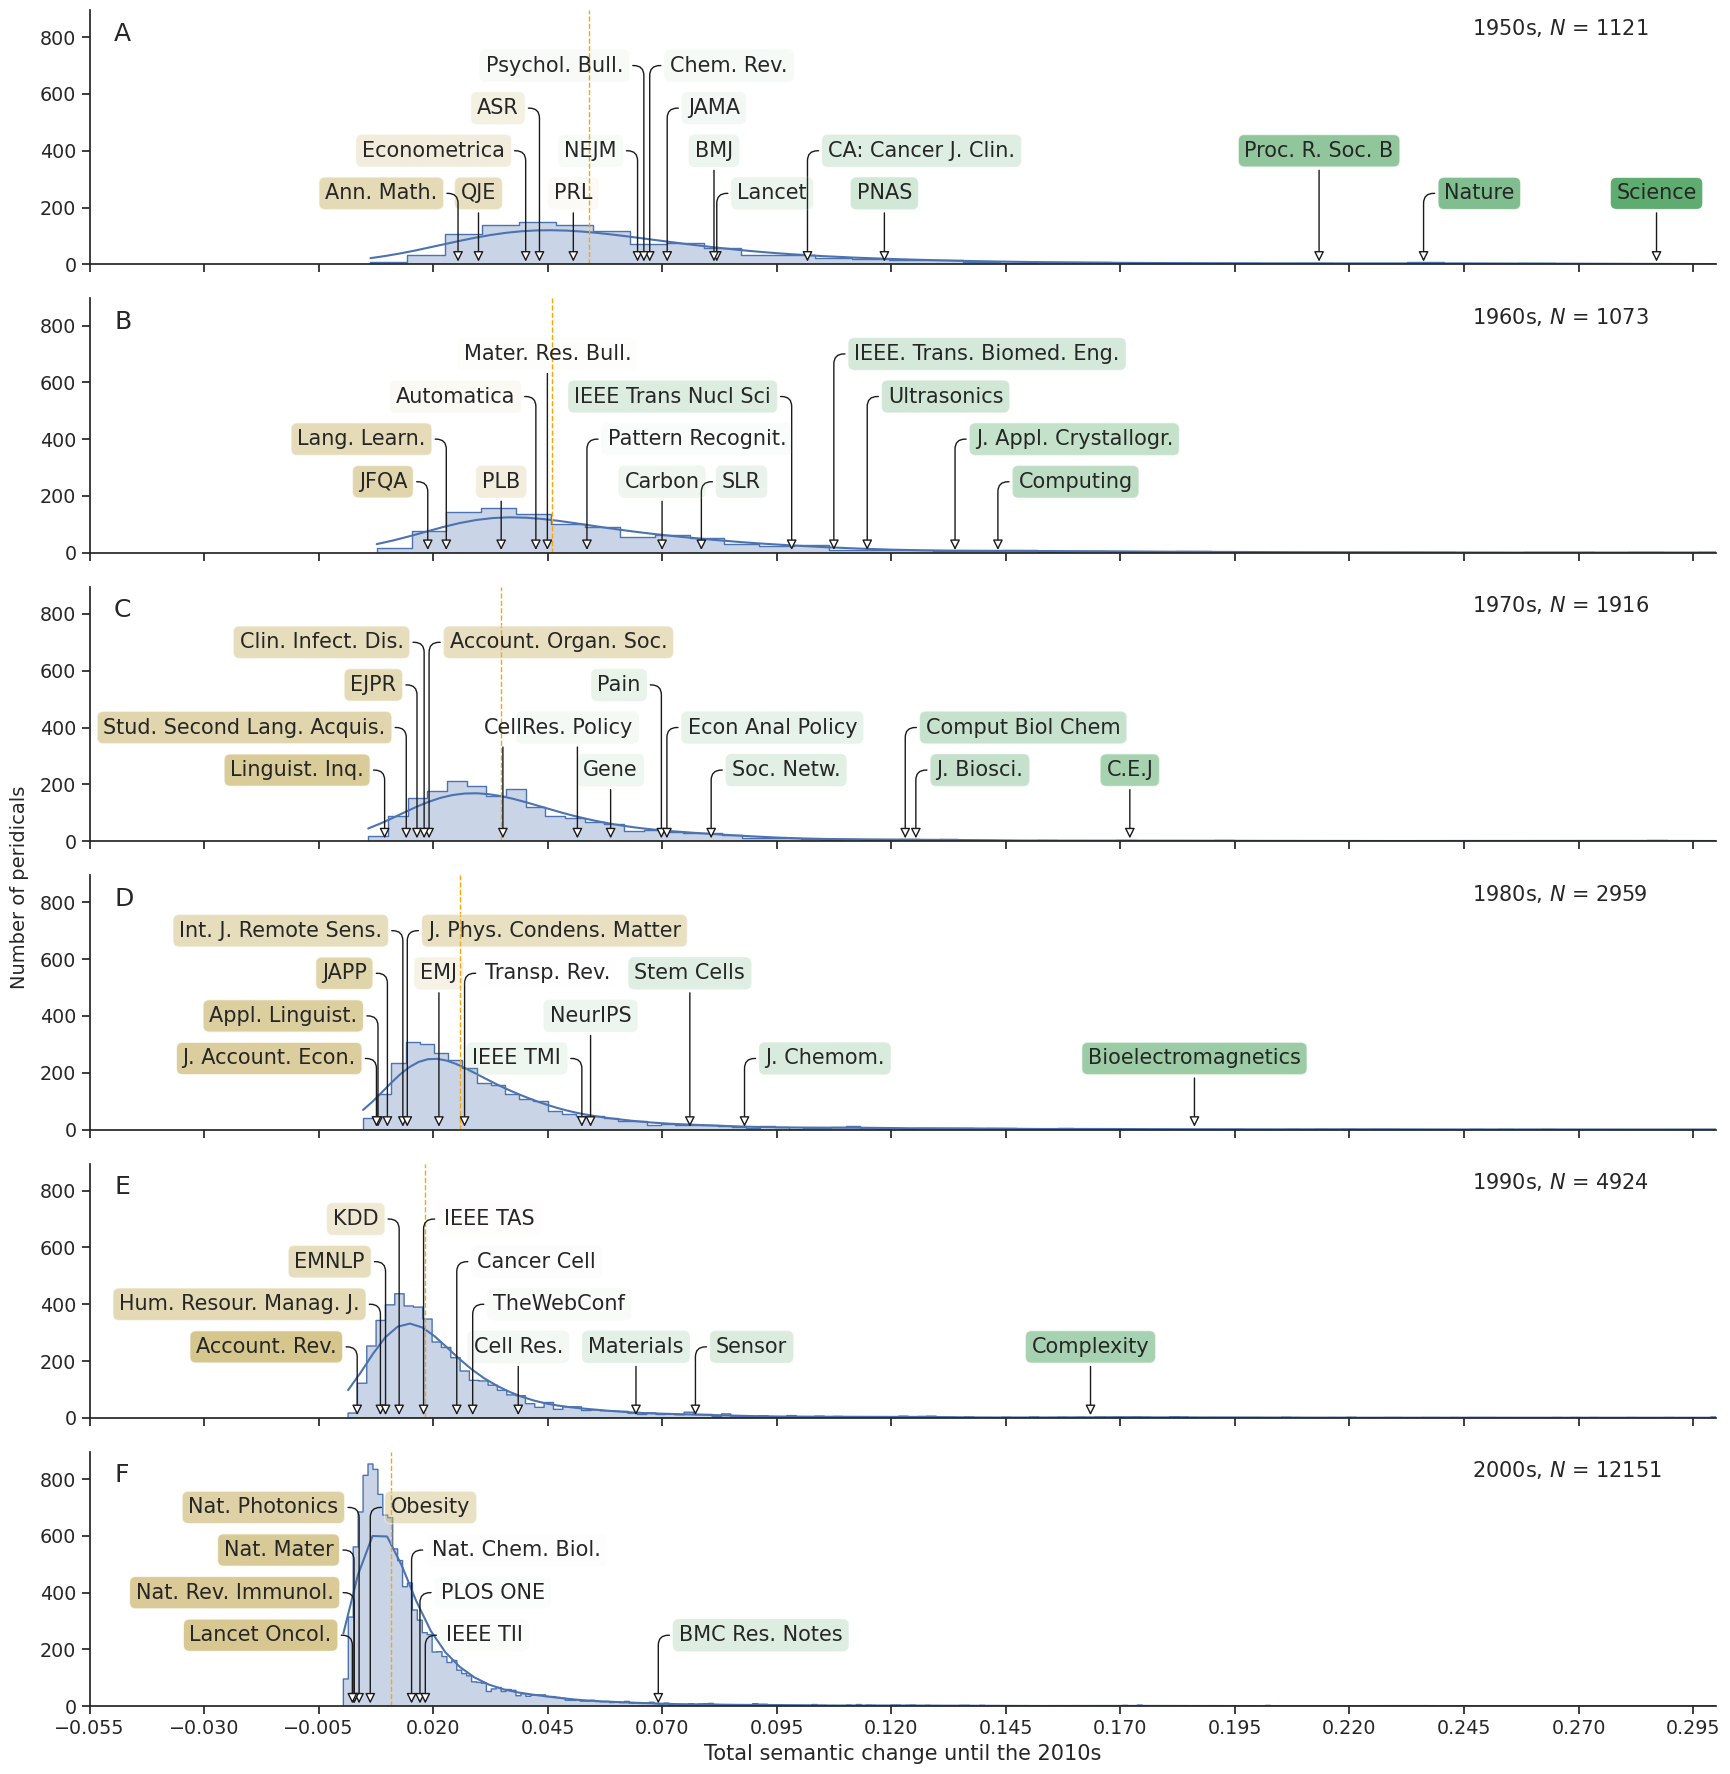

In [16]:
def annotate_n_and_decade(data, **kws):
    n = len(data)
    start_year = start_year_list[data.start_idx.unique()[0]]
    ax = plt.gca()
    ax.text(0.85, .9, f"{start_year}s, $N$ = {n}", transform=ax.transAxes)

def plot_median(x, **kwargs):
    ax = plt.gca()
    ax.axvline(x.median(), c='orange', ls='--', lw=1)

def annotate_periodical_name(data, opaque_value, **kwargs):
    selected_data = data[data.venue_name.isin(abbr_dict.keys())]
    display()
    ax = plt.gca()
    for index, row in selected_data.iterrows():
        TSC = row.total_semantic_change_2010s
        median = data.total_semantic_change_2010s.median()
        venue_name = row.venue_name

        if TSC <= median:
            c = 'y'
            alpha = (median - TSC) / median
        if TSC > median:
            c = 'g'
            alpha = (TSC - median) / (opaque_value - median)
        # ---------------------------adjust height---------------------------
        # low
        if venue_name in [# 1950s
                          'Science', 'Psychological Bulletin', 'Nature', 'Physical Review Letters', 
                          'Proceedings of the National Academy of Sciences of the United States of America', 
                          'The Lancet',
                          'Quarterly Journal of Economics', 'Annals of Mathematics', 
                          # 1960s
                          'Carbon', 'Stanford Law Review', 'Computing', 'Physics Letters B', 
                          'Journal of Financial and Quantitative Analysis',
                          'Atmosphere', 
                          # 1970s
                          'Linguistic Inquiry', 'Gene', 'Social Networks', 
                          'Civil Engineering', 'Journal of Biosciences',
                          # 1980s
                          'Journal of Chemometrics', 'Bioelectromagnetics',
                          'IEEE Transactions on Medical Imaging', 'Journal of Accounting and Economics', 
                          # 1990s
                          'The Accounting Review', 'Cell Research', 'Materials', 'Sensors', 'Complexity',
                          # 2000s
                          'Lancet Oncology', 'BMC Research Notes', 'IEEE Transactions on Industrial Informatics',
                         ]:
            label_y = 250
        # middle
        if venue_name in [# 1950s
                          'CA: A Cancer Journal for Clinicians', 'Econometrica', 'The New England Journal of Medicine', 
                          'Proceedings of The Royal Society B: Biological Sciences', 'BMJ',
                          # 1960s
                          'Language Learning', 'Journal of Applied Crystallography', 'Pattern Recognition', 
                          # 1970s
                          'Studies in Second Language Acquisition', 'Computational Biology and Chemistry', 'Cell', 'Research Policy',
                          'Economic Analysis and Policy', 
                          # 1980s
                          'neural information processing systems', 'Applied Linguistics', 
                          # 1990s
                          'Human Resource Management Journal', 'the web conference', 
                          # 2000s
                          'Nature Reviews Immunology', 'PLOS ONE', 
                          ]:
            label_y = 400
        # high
        if venue_name in [# 1950s
                          'JAMA', 'American Sociological Review', 
                          # 1960s
                          'Ultrasonics', 'Automatica', 'IEEE Transactions on Nuclear Science', 
                          # 1970s
                          'Life sciences in space research', 'European Journal of Political Research', 'Pain', 
                          # 1980s
                          'Journal of Accounting and Public Policy', 'Transport Reviews', 'Stem Cells',
                          'European Management Journal', 
                          # 1990s
                          'Cancer Cell', 'empirical methods in natural language processing',
                          # 2000s
                          'Nature Materials', 'Nature Chemical Biology',
                         ]:
            label_y = 550
        # ultra high
        if venue_name in [# 1950s
                          'Chemical Reviews', 'Psychological Bulletin', 
                          # 1960s
                          'IEEE Transactions on Biomedical Engineering', 'Materials Research Bulletin',
                          # 1970s
                          'Accounting Organizations and Society', 
                          'Clinical Infectious Diseases', 
                          # 1980s
                          'Journal of Physics: Condensed Matter', 'International Journal of Remote Sensing',
                          # 1990s
                          'knowledge discovery and data mining', 'IEEE Transactions on Applied Superconductivity',
                          # 2000s
                          'Nature Photonics', 'Obesity',
                          ]:
            label_y = 700
            
        # ---------------------------adjust arrow direction---------------------------
        # straight arrow
        if venue_name in [# 1950s
                          'Proceedings of the National Academy of Sciences of the United States of America',
                          'Quarterly Journal of Economics', 'BMJ', 'Physical Review Letters', 
                          'Proceedings of The Royal Society B: Biological Sciences', 'Science', 
                          # 1960s
                          'Carbon', 'Materials Research Bulletin', 'Physics Letters B', 
                          # 1970s
                          'Gene', 'Research Policy',
                          'Civil Engineering', 'Cell',
                          # 1980s
                          'Stem Cells', 'Bioelectromagnetics', 'European Management Journal', 
                          'neural information processing systems', 
                          # 1990s
                          'Complexity', 'Cell Research', 'Materials',
                         # 2000s

                         ]:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.", fc="w", color='k')
            label_x = TSC
            haligh = 'center'
            
        # bend arrow
        else:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="angle,angleA=0,angleB=-90,rad=10", fc="w", color='k')
            # bend right
            if venue_name in [# 1950s
                              'Proceedings of the National Academy of Sciences of the United States of America',
                              'The New England Journal of Medicine', 'CA: A Cancer Journal for Clinicians',
                              'Chemical Reviews', 'The Lancet', 'Nature', 'JAMA', 
                              # 1960s
                              'IEEE Transactions on Biomedical Engineering', 'Journal of Applied Crystallography', 
                              'Pattern Recognition', 'Computing', 'Ultrasonics', 
                              'Stanford Law Review', 
                              # 1970s
                              'Accounting Organizations and Society', 'Social Networks', 'Computational Biology and Chemistry', 
                              'Economic Analysis and Policy', 'Life sciences in space research', 'Journal of Biosciences', 
                              # 1980s
                              'Transport Reviews', 
                              'Journal of Chemometrics', 'Journal of Physics: Condensed Matter', 
                              # 1990s
                              'the web conference', 'Cancer Cell', 'Sensors', 'IEEE Transactions on Applied Superconductivity', 
                              # 2000s
                              'Obesity', 'Nature Chemical Biology', 'IEEE Transactions on Industrial Informatics', 'PLOS ONE', 
                              'BMC Research Notes',
                             ]:
                label_x = TSC + 0.0045
                haligh = 'left'
            # bend left
            if venue_name in [# 1950s
                              'Econometrica', 'Annals of Mathematics', 'Psychological Bulletin', 
                              'The New England Journal of Medicine', 'Journal of Financial and Quantitative Analysis', 
                              'American Sociological Review', 
                              # 1960s
                              'Atmosphere', 'IEEE Transactions on Nuclear Science', 'Automatica', 'Language Learning',
                              # 1970s
                              'Linguistic Inquiry', 'Studies in Second Language Acquisition', 
                              'European Journal of Political Research',
                              'Clinical Infectious Diseases', 'Pain', 
                              # 1980s
                              'Applied Linguistics', 'Journal of Accounting and Economics', 'IEEE Transactions on Medical Imaging',
                              'Journal of Accounting and Public Policy', 'International Journal of Remote Sensing',
                             # 1990s
                              'The Accounting Review', 'Human Resource Management Journal', 
                              'empirical methods in natural language processing', 'knowledge discovery and data mining', 
                             # 2000s
                              'Nature Reviews Immunology', 'Nature Materials', 'Lancet Oncology', 'Nature Photonics', 
                              
            ]: 
                label_x = TSC - 0.0045
                haligh = 'right'

        bbox_props = dict(boxstyle="round", fc=c, ec="1", alpha=alpha)
        ax.annotate(abbr_dict[venue_name], xy=(TSC, 0), xytext=(label_x, label_y), ha=haligh, va="center",
                    size=15, bbox = bbox_props, arrowprops = arrow_props)

plt.figure(dpi=300)
sns.set(style='white', font_scale=1.25)
g2 = sns.FacetGrid(local_semantic_change_df, 
                   row="start_idx", height=3, aspect=6, margin_titles=True)
g2.tick_params(axis='both', bottom='on',left='on')
g2.set(xlim=(-0.05, 0.3), xticks=np.arange(-0.055, 0.3, 0.025), yticks=np.arange(0, 1000, 200))

g2.map_dataframe(sns.histplot, x="total_semantic_change_2010s", kde=True, element='step', alpha=0.3)
g2.map(plot_median, 'total_semantic_change_2010s')
g2.map_dataframe(annotate_n_and_decade)
g2.map_dataframe(annotate_periodical_name, data=local_semantic_change_df, opaque_value=0.3)

panel_labels = ['A', 'B', 'C', 'D', 'E', 'F']
for i in range(g2.axes.flatten().shape[0]):
    ax = g2.axes.flatten()[i]
    ax.set_ylabel('')
    ax.text(0.015, .88, panel_labels[i], fontsize=18, transform=ax.transAxes)
    
g2.set_titles(row_template='')
g2.set_axis_labels('Total semantic change until the 2010s')
g2.fig.supylabel('Number of peridicals', x=0.01, fontsize=14)

plt.show()

In [17]:
g2.savefig('total_local_semantic_change_k_10.pdf', 
          dpi = 300, 
          facecolor='white', 
          transparent=False, 
          bbox_inches='tight')

## Aggregate total local semantic change into discipline level

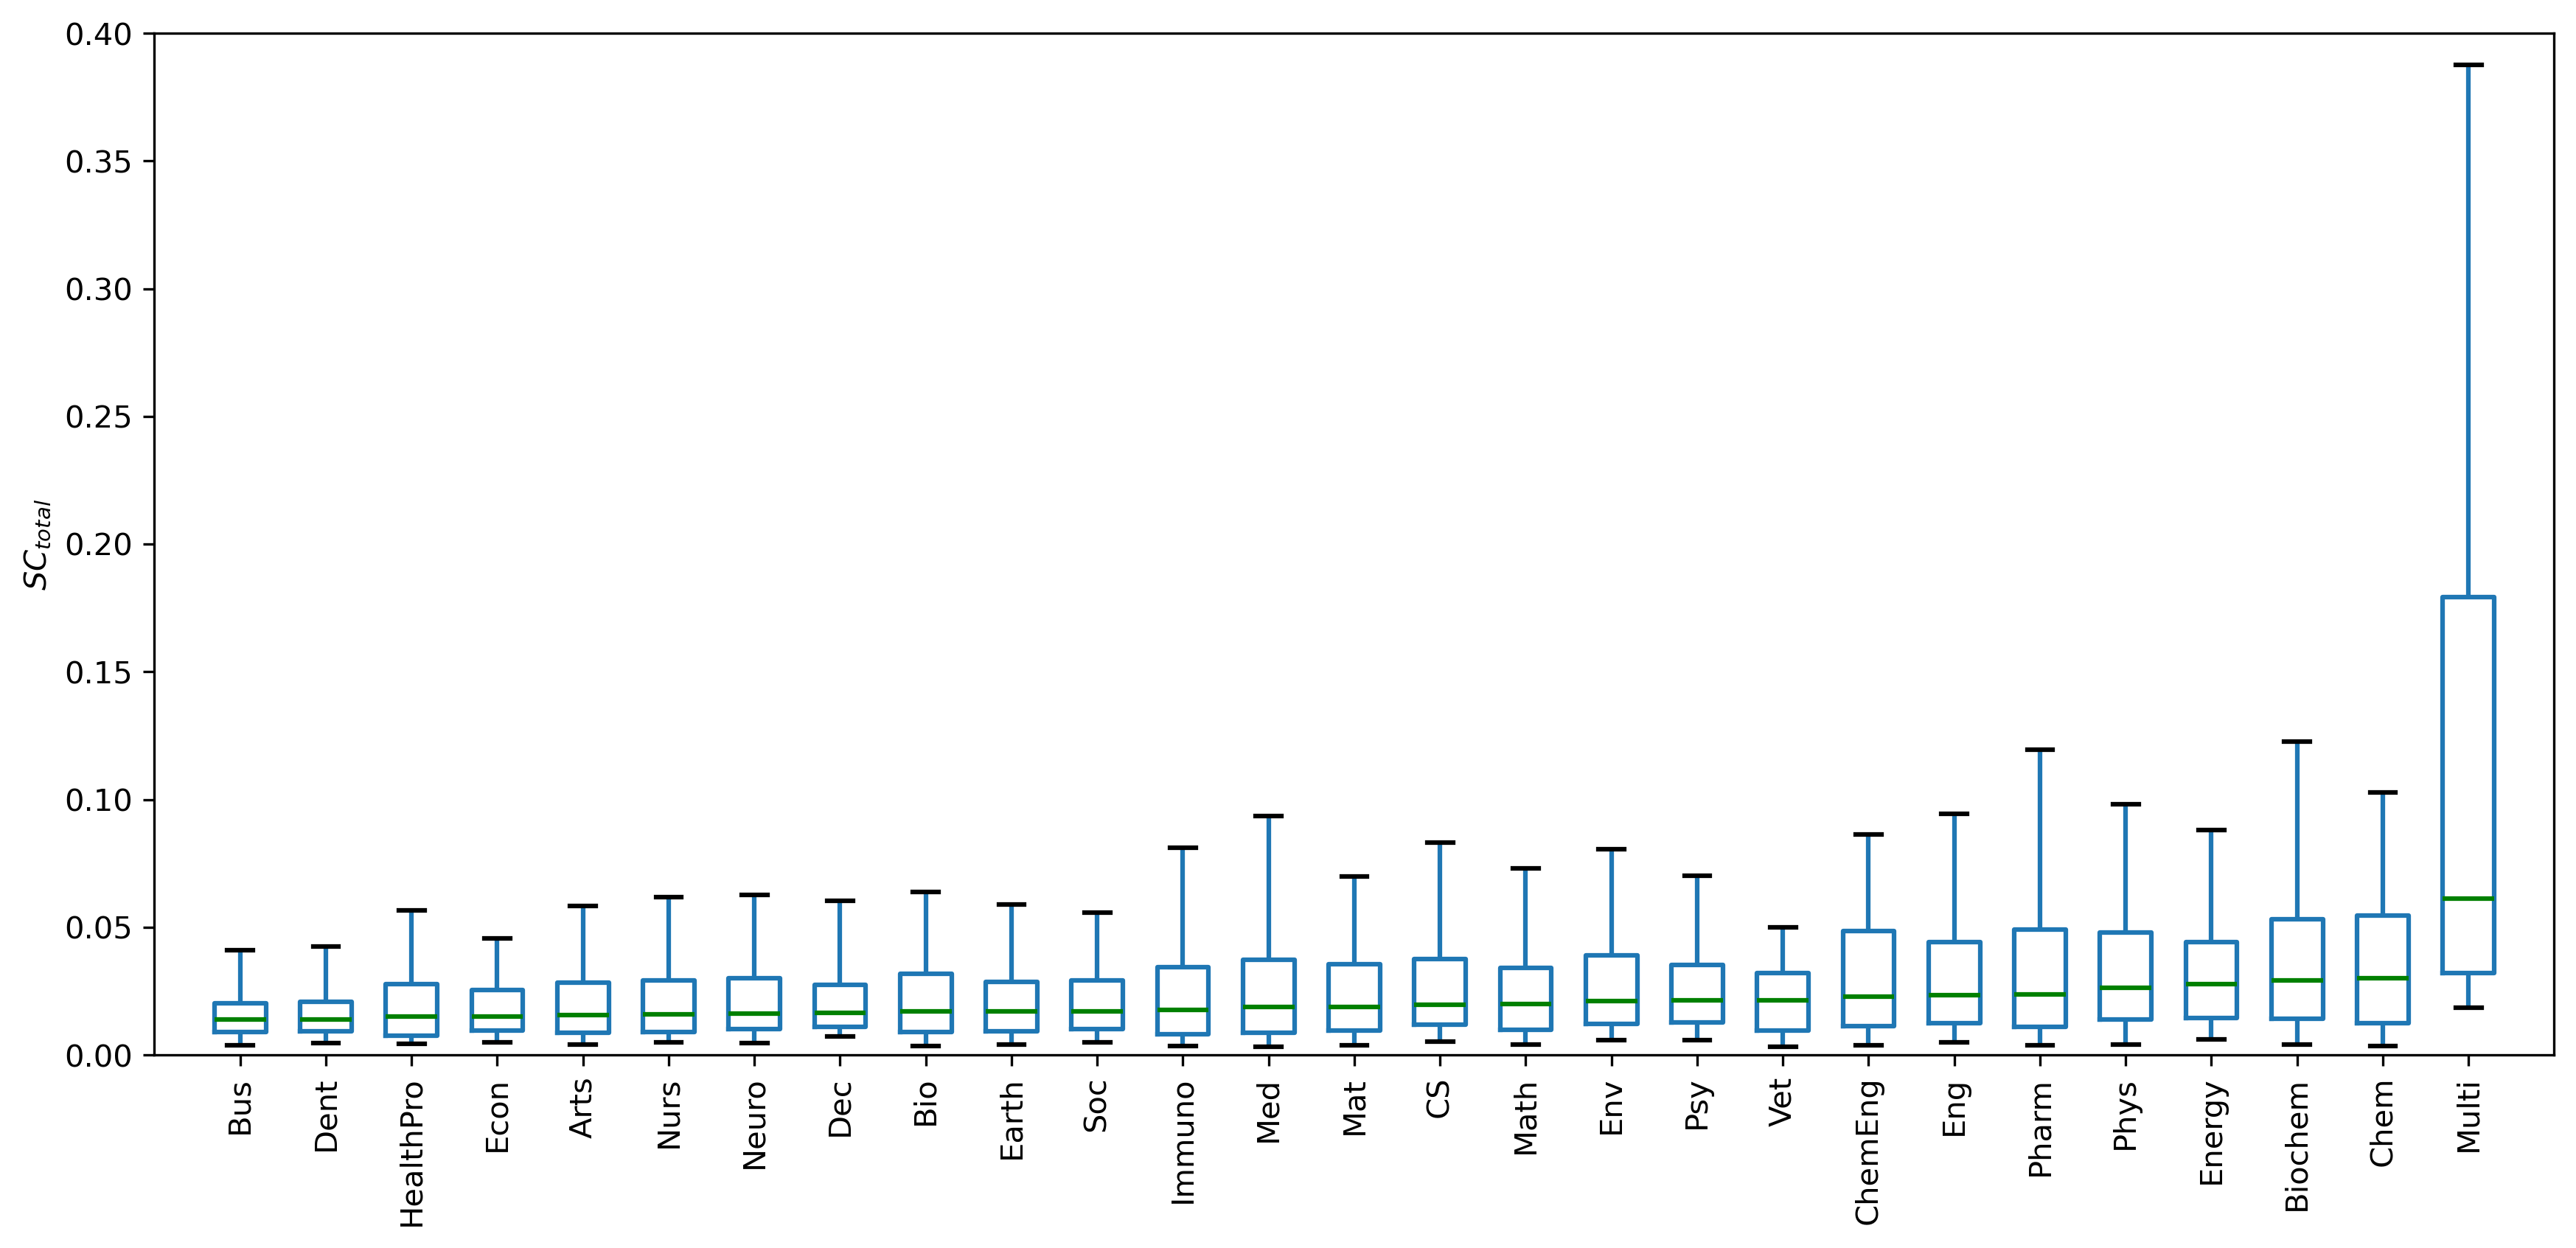

In [61]:
local_semantic_change_df_rename = local_semantic_change_df.copy()
local_semantic_change_df_rename.scopus_label = local_semantic_change_df_rename.scopus_label.replace(model.disc2abbr)
col_name = 'total_semantic_change_2010s'

plt.figure(figsize=(14,6), dpi=300)
plt.xticks(rotation=90)
g3 = sns.boxplot(x="scopus_label", y="total_semantic_change_2010s", data=local_semantic_change_df_rename, 
                 order=local_semantic_change_df_rename.groupby('scopus_label').agg({col_name:'median'}).sort_values(by=col_name).index.to_list(),
                 whis=(5,95), fliersize=0, fill=False, gap=0.25,
                 medianprops={'color': 'g'},
                 capprops={'color': 'k'},
                )
g3.set(xlabel='',
       ylabel='$SC_{total}$',
       ylim=(0.0, 0.4),
       xlim=(-1, len(model.disc2abbr))
      )
plt.show()

In [62]:
g3.get_figure().savefig('total_local_semantic_change_by_discipline_k_10.pdf', 
          dpi = 300, 
          facecolor='white', 
          transparent=False, 
          bbox_inches='tight')

# Bootstrap

### Generate data

#### Metrics

In [11]:
# define metrics:

def median_shifted_ratio(P_samples=None, Q_samples=None, get_ylabel=False):
    if get_ylabel:
        return r'$\frac{\Delta median(SC_{total})}{median(SC_{total})}$'
    else:
        return (np.median(P_samples) - np.median(Q_samples)) / np.median(P_samples) 

def z_score_diff(P_samples, Q_samples):
    z_p = (P_samples - np.mean(P_samples)) / np.std(P_samples)
    z_q = (Q_samples - np.mean(Q_samples)) / np.std(Q_samples)
    # return np.mean(np.abs(z_p - z_q))
    return np.mean(z_p - z_q)

def mean_difference(P_samples, Q_samples):
    differences = P_samples - Q_samples
    return np.mean(differences)

def cohens_d(P_samples=None, Q_samples=None, get_ylabel=False):
    if get_ylabel:
        return 'cohen\'s d'
    else:
        diff_mean = np.mean(P_samples) - np.mean(Q_samples)
        pooled_std = np.sqrt((np.std(P_samples)**2 + np.std(Q_samples)**2) / 2)
        return diff_mean / pooled_std

def cohens_d_paired(P_samples=None, Q_samples=None, get_ylabel=False):
    if get_ylabel:
        return 'cohen\'s d for paired data'
    else:
        diff = P_samples - Q_samples
        mean_diff = np.mean(diff)
        std_diff = np.std(diff, ddof=1)  # ddof=1 表示使用样本标准差
        return mean_diff / std_diff

def glass_delta(P_samples, Q_samples):
    # 计算均值差
    mean_diff = np.mean(P_samples) - np.mean(Q_samples)
    # 使用 P_samples 的标准差进行标准化
    std_control = np.std(P_samples, ddof=1)
    glass_delta = mean_diff / std_control
    return glass_delta

def paired_t_test(P_samples, Q_samples):
    from scipy import stats
    t_statistic, p_value = stats.ttest_rel(P_samples, Q_samples)
    return t_statistic

def ks_test(P_samples, Q_samples):
    from scipy.stats import ks_2samp
    return ks_2samp(P_samples, Q_samples).statistic

def mannwhitney(P_samples=None, Q_samples=None, get_ylabel=False):
    from scipy.stats import mannwhitneyu
    U1, p = mannwhitneyu(P_samples, Q_samples)
    U2 = len(P_samples)*len(Q_samples) - U1
    ylabel = r'$\frac{min(U_{1}, U_{2})}{n^2}$'
    if get_ylabel:
        return ylabel
    else:
        return min(U1, U2)/(len(P_samples)*len(Q_samples))
    # return U1

def wilcoxon(P_samples=None, Q_samples=None, get_ylabel=False):
    from scipy.stats import wilcoxon
    ylabel = r'$\frac{W}{\sum_{k=1}^{n} k}$'
    if get_ylabel:
        return ylabel
    else:
        res = wilcoxon(P_samples, Q_samples)
        rank_sum = len(P_samples) * (len(P_samples) + 1) // 2
        return(res.statistic/rank_sum)
        # return(res.zstatistic)
        # return res.pvalue

def kl_divergence(P_pdf, Q_pdf):
    from scipy.stats import entropy
    kl_divergence_value = entropy(P_pdf, Q_pdf)
    return kl_divergence_value

def js_divergence(P_pdf, Q_pdf):
    from scipy.spatial.distance import jensenshannon
    return jensenshannon(P_pdf, Q_pdf)

def hellinger_dist(P_pdf, Q_pdf):
    return np.sqrt(0.5 * np.sum((np.sqrt(P_pdf) - np.sqrt(Q_pdf))**2))

def bhattacharyya_dist(P_pdf, Q_pdf):
    return -np.log(np.sum(np.sqrt(P_pdf * Q_pdf)))

def total_variation_dist(P_pdf, Q_pdf):
    return 0.5 * np.sum(np.abs(P_pdf - Q_pdf))
    
def is_kde_required(distance_metric):
    no_kde_metrics = [median_shifted_ratio, z_score_diff, cohens_d, cohens_d_paired, glass_delta, paired_t_test,
                      mean_difference, ks_test, mannwhitney, wilcoxon]
    return distance_metric not in no_kde_metrics

In [6]:
metric = wilcoxon

#### By decade of establishment

In [10]:
import pandas as pd
from tqdm import tqdm

def pad_list_with_none(lst, target_length=6, padding_from: str='left'):
    print('padding length:', target_length - len(lst))
    padding = [None] * (target_length - len(lst))  # generate None list
    if padding_from == 'right':
        return lst + padding  # padding from right
    if padding_from == 'left':
        return padding + lst  # padding from left

def random_replace_per_row(df: pd.DataFrame, column_to_drop: str, remain_columns: list):
    col_to_drop_idx = df.columns.get_loc(column_to_drop)
    # generate a random column index for each row
    num_rows = len(df)
    random_columns_idx = np.random.randint(0, len(remain_columns), size=num_rows)
    # create a 1D array to store candicate values for each row
    replacement_values = df[remain_columns].values[np.arange(num_rows), random_columns_idx]
    df.iloc[:, col_to_drop_idx] = replacement_values
    return df

def measure_period_importance(local_semantic_change_df, metric):
    from scipy.stats import gaussian_kde

    start_idxs = [0, 1, 2, 3, 4]
    period_list = ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 
                   'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
    found_decade_list = ['1950s', '1960s', '1970s', '1980s', '1990s']
    n_iter = 1000
    all_age_group_statistics_df = pd.DataFrame(columns=['founded decade', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s'])
    all_period_mean = {'1950s': [], '1960s': [], '1970s': [], '1980s': [], '1990s': []} # store the avg of bootstrapping distributions, for plotting 6 subplots on the left

    for start_idx in start_idxs:
        sampling_df = local_semantic_change_df[local_semantic_change_df.start_idx==start_idx].copy()
        print(f'processing {len(sampling_df)} periodicals established in {found_decade_list[start_idx]}')
        sampling_df.drop(columns=['total_semantic_change_1960s', 'total_semantic_change_1970s', 'total_semantic_change_1980s',
                                  'total_semantic_change_1990s', 'total_semantic_change_2000s', 'total_semantic_change_2010s'], inplace=True)
        # get the original distribution
        original_values = sampling_df[period_list[start_idx:]].sum(axis=1).values
        if is_kde_required(metric):
            original_kde = gaussian_kde(original_values)
            x_range = np.linspace(min(original_values), max(original_values), 100) # make a range for x
            original_pdf = original_kde(x_range)  # calculate the PDF for the original distribution
            epsilon = 1e-10
            original_pdf = np.maximum(original_pdf, epsilon)  # avoid zero division
        
        all_period_statistics_list = []
        for period in period_list[start_idx:]:
            print('period to drop:', period)    
            column_to_drop = period

            remain_columns = period_list[start_idx:].copy()
            remain_columns.remove(period)
            print('remain periods:', remain_columns)

            bootstrap_results = np.zeros((n_iter, len(sampling_df)))  # pre allocate memory, median of all periodials, shape: (n_iter, n_periodicals)
            statistics_results = np.zeros(n_iter)  # shape: (n_iter,)
            print('start iterating...')
            for i in tqdm(range(n_iter), desc='Iterations'):
                replaced_df = random_replace_per_row(sampling_df.copy(), column_to_drop, remain_columns) # make replacement for each row
                bootstrap_values = replaced_df[period_list[start_idx:]].sum(axis=1).values
                bootstrap_results[i, :] = bootstrap_values

                if is_kde_required(metric):
                    bootstrap_kde = gaussian_kde(bootstrap_values) # calculate the KDE for the bootstrap distribution
                    bootstrap_pdf = np.maximum(bootstrap_kde(x_range), 1e-10)
                    statistics = metric(original_pdf, bootstrap_pdf)  # calculation based on KDE
                else:
                    statistics = metric(original_values, bootstrap_values)  # don't use KDE
                statistics_results[i] = statistics  # store the statistics for each bootstrap sample

            print('mean of statistics:', np.mean(statistics_results))
            all_period_statistics_list.append(statistics_results)

            # store the average of all bootstrap sample, shape: (n_periodicals,), to plot 6 subplots on the left
            all_period_mean[found_decade_list[start_idx]].append(np.mean(bootstrap_results, axis=0))
                
        print('length of generate data:', len(all_period_statistics_list))
        all_period_statistics_list = pad_list_with_none(all_period_statistics_list)

        # creat a new row and add the new row to the DataFrame, each row represents an age group
        new_row = pd.DataFrame({
            'founded decade': [found_decade_list[start_idx]],
            '1950_1960': [all_period_statistics_list[0]],
            '1960_1970': [all_period_statistics_list[1]],
            '1970_1980': [all_period_statistics_list[2]],
            '1980_1990': [all_period_statistics_list[3]],
            '1990_2000': [all_period_statistics_list[4]],
            '2000_2010': [all_period_statistics_list[5]]
        })
        all_age_group_statistics_df = pd.concat([all_age_group_statistics_df, new_row], ignore_index=True)
        print('\n')

    return all_age_group_statistics_df, all_period_mean

In [16]:
metric = cohens_d_paired

In [ ]:
all_age_group_statistics_df, all_period_mean = measure_period_importance(local_semantic_change_df, metric=metric)

processing 1121 periodicals established in 1950s
period to drop: semantic_change_1960s
remain periods: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1455.83it/s]


mean of statistics: 0.33819713646173477
period to drop: semantic_change_1970s
remain periods: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1448.64it/s]


mean of statistics: 0.10263865740597249
period to drop: semantic_change_1980s
remain periods: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1477.93it/s]


mean of statistics: -0.12306119728833437
period to drop: semantic_change_1990s
remain periods: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1456.75it/s]


mean of statistics: -0.14376694376766683
period to drop: semantic_change_2000s
remain periods: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1461.73it/s]


mean of statistics: -0.09100926616415382
period to drop: semantic_change_2010s
remain periods: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1453.63it/s]


mean of statistics: -0.15446829243004323
length of generate data: 6
padding length: 0


processing 1073 periodicals established in 1960s
period to drop: semantic_change_1970s
remain periods: ['semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1483.16it/s]


mean of statistics: 0.3225584739148617
period to drop: semantic_change_1980s
remain periods: ['semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1494.78it/s]


mean of statistics: -0.01133229773455605
period to drop: semantic_change_1990s
remain periods: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1487.05it/s]


mean of statistics: -0.09058098797686398
period to drop: semantic_change_2000s
remain periods: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1488.62it/s]


mean of statistics: -0.1244340723156929
period to drop: semantic_change_2010s
remain periods: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1508.26it/s]


mean of statistics: -0.122595741212368
length of generate data: 5
padding length: 1


processing 1916 periodicals established in 1970s
period to drop: semantic_change_1980s
remain periods: ['semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1331.67it/s]


mean of statistics: 0.1467301494702697
period to drop: semantic_change_1990s
remain periods: ['semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1360.07it/s]


mean of statistics: -0.0736424463018775
period to drop: semantic_change_2000s
remain periods: ['semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1348.98it/s]


mean of statistics: -0.0458446560902521
period to drop: semantic_change_2010s
remain periods: ['semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1351.68it/s]


mean of statistics: -0.03751640974124894
length of generate data: 4
padding length: 2


processing 2959 periodicals established in 1980s
period to drop: semantic_change_1990s
remain periods: ['semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1250.86it/s]


mean of statistics: 0.12049420344829559
period to drop: semantic_change_2000s
remain periods: ['semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1245.75it/s]


mean of statistics: -0.004308228478414094
period to drop: semantic_change_2010s
remain periods: ['semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1251.18it/s]


mean of statistics: -0.12913263861835003
length of generate data: 3
padding length: 3


processing 4924 periodicals established in 1990s
period to drop: semantic_change_2000s
remain periods: ['semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1068.84it/s]


mean of statistics: 0.13011500239372253
period to drop: semantic_change_2010s
remain periods: ['semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1061.27it/s]

mean of statistics: -0.13011503219604492
length of generate data: 2
padding length: 4




#### By discipline

In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def random_replace_per_row(df: pd.DataFrame, column_to_drop: str, remain_columns: list):
    col_to_drop_idx = df.columns.get_loc(column_to_drop)
    # generate a random column index for each row
    num_rows = len(df)
    random_columns_idx = np.random.randint(0, len(remain_columns), size=num_rows)
    # create a 1D array to store candicate values for each row
    replacement_values = df[remain_columns].values[np.arange(num_rows), random_columns_idx]
    df.iloc[:, col_to_drop_idx] = replacement_values
    return df

def measure_period_importance(local_semantic_change_df, metric):
    period_list = ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 
                   'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
    period_column_name_list = ['1950_1960', '1960_1970', '1970_1980', '1980_1990', '1990_2000', '2000_2010']
    start_idx_list = [0, 1, 2, 3, 4]
    # start_idx_list = [0]
    length_list = [6, 5, 4, 3, 2]
    n_iter = 100
    all_discipline_statistics_df = pd.DataFrame(columns=['discipline', 'founded_decade',
                                                         '1950_1960', '1960_1970', '1970_1980', '1980_1990', '1990_2000', '2000_2010'])

    for start_idx in start_idx_list:
        length = length_list[start_idx]
        sampling_df = local_semantic_change_df[(local_semantic_change_df.start_idx == start_idx)].copy()
        print(f'processing {len(sampling_df)} periodicals established in {period_list[start_idx][-5:]}...')
        print(f'for these periodccals, length is {length}')

        print('calculating original distribution...')
        original_values_dict = {}
        print('mean of original distribution for' )
        for discipline in model.disc2abbr.keys():
            original_values_dict[discipline] = sampling_df[sampling_df.scopus_label == discipline][period_list].sum(axis=1).values
            print(f'{len(sampling_df[sampling_df.scopus_label == discipline])} periodicals in {discipline}:', np.mean(original_values_dict[discipline]))
        print('\n')
        all_discipline_statistic_series_dict = {key: [np.zeros(n_iter) for i in range(6)] for key in model.disc2abbr.keys()}

        # 遍历时间段
        for period_idx, period in enumerate(period_list[start_idx:]):
            print('period to drop:', period[-5:]) 
            column_to_drop = period

            remain_columns = period_list[start_idx:].copy()
            remain_columns.remove(period)
            print('remain periods:', remain_columns)
            # 进行 n_iter 次迭代
            for i in tqdm(range(n_iter), desc='Iterations'):
                replaced_df = random_replace_per_row(sampling_df.copy(), column_to_drop, remain_columns) # make replacement for each row
                for discipline in model.disc2abbr.keys():
                    bootstrap_values = replaced_df[replaced_df.scopus_label == discipline][period_list].sum(axis=1).values
                    original_values = original_values_dict[discipline]
                    # 使用 metric 计算统计量并保存
                    all_discipline_statistic_series_dict[discipline][period_idx][i] = metric(original_values, bootstrap_values)

        for discipline, series_list in all_discipline_statistic_series_dict.items():
            new_row_data = {'discipline': [discipline], 'founded_decade': [period_list[start_idx][-5:]]}
            for period_idx, column_name in enumerate(period_column_name_list[-length:]): # add new keys
                new_row_data[column_name] = [series_list[period_idx]]
            all_discipline_statistics_df = pd.concat([all_discipline_statistics_df, pd.DataFrame(new_row_data)], ignore_index=True)
        print('\n')

    return all_discipline_statistics_df

In [8]:
metric = median_shifted_ratio
all_discipline_statistics_df = measure_period_importance(local_semantic_change_df, metric=metric)

processing 1121 periodicals established in 1960s...
for these periodccals, length is 6
calculating original distribution...
mean of original distribution for
47 periodicals in Biochemistry, Genetics and Molecular Biology: 0.07849772
55 periodicals in Earth and Planetary Sciences: 0.047694635
239 periodicals in Medicine: 0.08146715
34 periodicals in Physics and Astronomy: 0.08585714
143 periodicals in Agricultural and Biological Sciences: 0.055733666
26 periodicals in Immunology and Microbiology: 0.06558048
37 periodicals in Chemistry: 0.07322081
7 periodicals in Neuroscience: 0.13453676
16 periodicals in Materials Science: 0.069870695
129 periodicals in Social Sciences: 0.050166994
5 periodicals in Environmental Science: 0.06892723
19 periodicals in Engineering: 0.09394639
13 periodicals in Pharmacology, Toxicology and Pharmaceutics: 0.13624342
34 periodicals in Psychology: 0.058661014
84 periodicals in Arts and Humanities: 0.05321497
73 periodicals in Mathematics: 0.052262798
7 period

Iterations: 100%|██████████| 100/100 [00:01<00:00, 62.85it/s]


period to drop: 1970s
remain periods: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 64.53it/s]


period to drop: 1980s
remain periods: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 64.25it/s]


period to drop: 1990s
remain periods: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 64.99it/s]


period to drop: 2000s
remain periods: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 64.39it/s]


period to drop: 2010s
remain periods: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 64.60it/s]




processing 1073 periodicals established in 1970s...
for these periodccals, length is 5
calculating original distribution...
mean of original distribution for
35 periodicals in Biochemistry, Genetics and Molecular Biology: 0.08423086
46 periodicals in Earth and Planetary Sciences: 0.038322818
150 periodicals in Medicine: 0.07256312
51 periodicals in Physics and Astronomy: 0.06267841
89 periodicals in Agricultural and Biological Sciences: 0.04334585
8 periodicals in Immunology and Microbiology: 0.045515068
35 periodicals in Chemistry: 0.06277044
9 periodicals in Neuroscience: 0.049369346
27 periodicals in Materials Science: 0.046512604
141 periodicals in Social Sciences: 0.042711865
17 periodicals in Environmental Science: 0.06576028
64 periodicals in Engineering: 0.064314395
14 periodicals in Pharmacology, Toxicology and Pharmaceutics: 0.08763778
32 periodicals in Psychology: 0.044133376
68 periodicals in Arts and Humanities: 0.03869185
56 periodicals in Mathematics: 0.049986515
6 per

Iterations: 100%|██████████| 100/100 [00:01<00:00, 64.05it/s]


period to drop: 1980s
remain periods: ['semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 63.94it/s]


period to drop: 1990s
remain periods: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 63.61it/s]


period to drop: 2000s
remain periods: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 63.90it/s]


period to drop: 2010s
remain periods: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 63.52it/s]




processing 1916 periodicals established in 1980s...
for these periodccals, length is 4
calculating original distribution...
mean of original distribution for
45 periodicals in Biochemistry, Genetics and Molecular Biology: 0.061367817
62 periodicals in Earth and Planetary Sciences: 0.03562869
295 periodicals in Medicine: 0.04761432
49 periodicals in Physics and Astronomy: 0.048919227
110 periodicals in Agricultural and Biological Sciences: 0.032873154
27 periodicals in Immunology and Microbiology: 0.03337328
25 periodicals in Chemistry: 0.05057148
19 periodicals in Neuroscience: 0.03021904
30 periodicals in Materials Science: 0.044816077
326 periodicals in Social Sciences: 0.032167137
39 periodicals in Environmental Science: 0.05584649
69 periodicals in Engineering: 0.060111508
23 periodicals in Pharmacology, Toxicology and Pharmaceutics: 0.05831023
68 periodicals in Psychology: 0.043727037
150 periodicals in Arts and Humanities: 0.0352864
63 periodicals in Mathematics: 0.03509087
12 

Iterations: 100%|██████████| 100/100 [00:01<00:00, 60.85it/s]


period to drop: 1990s
remain periods: ['semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 61.24it/s]


period to drop: 2000s
remain periods: ['semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 61.32it/s]


period to drop: 2010s
remain periods: ['semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 60.89it/s]




processing 2959 periodicals established in 1990s...
for these periodccals, length is 3
calculating original distribution...
mean of original distribution for
72 periodicals in Biochemistry, Genetics and Molecular Biology: 0.047788695
80 periodicals in Earth and Planetary Sciences: 0.021945152
502 periodicals in Medicine: 0.037965253
56 periodicals in Physics and Astronomy: 0.03570803
183 periodicals in Agricultural and Biological Sciences: 0.02249962
41 periodicals in Immunology and Microbiology: 0.031160697
45 periodicals in Chemistry: 0.045060225
24 periodicals in Neuroscience: 0.0240722
53 periodicals in Materials Science: 0.029360985
407 periodicals in Social Sciences: 0.026609514
45 periodicals in Environmental Science: 0.04362699
135 periodicals in Engineering: 0.044070497
42 periodicals in Pharmacology, Toxicology and Pharmaceutics: 0.043426204
90 periodicals in Psychology: 0.025840746
172 periodicals in Arts and Humanities: 0.026272485
70 periodicals in Mathematics: 0.0297130

Iterations: 100%|██████████| 100/100 [00:01<00:00, 58.01it/s]


period to drop: 2000s
remain periods: ['semantic_change_1990s', 'semantic_change_2010s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 57.56it/s]


period to drop: 2010s
remain periods: ['semantic_change_1990s', 'semantic_change_2000s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 57.51it/s]




processing 4924 periodicals established in 2000s...
for these periodccals, length is 2
calculating original distribution...
mean of original distribution for
118 periodicals in Biochemistry, Genetics and Molecular Biology: 0.03524155
69 periodicals in Earth and Planetary Sciences: 0.016684577
796 periodicals in Medicine: 0.026582478
92 periodicals in Physics and Astronomy: 0.025856886
211 periodicals in Agricultural and Biological Sciences: 0.019058453
38 periodicals in Immunology and Microbiology: 0.020309115
64 periodicals in Chemistry: 0.024753567
20 periodicals in Neuroscience: 0.011389784
74 periodicals in Materials Science: 0.025425645
608 periodicals in Social Sciences: 0.02052912
73 periodicals in Environmental Science: 0.030228239
175 periodicals in Engineering: 0.028112357
37 periodicals in Pharmacology, Toxicology and Pharmaceutics: 0.035923406
118 periodicals in Psychology: 0.02176322
249 periodicals in Arts and Humanities: 0.018284962
162 periodicals in Mathematics: 0.02

Iterations: 100%|██████████| 100/100 [00:01<00:00, 52.14it/s]


period to drop: 2010s
remain periods: ['semantic_change_2000s']


Iterations: 100%|██████████| 100/100 [00:01<00:00, 51.93it/s]

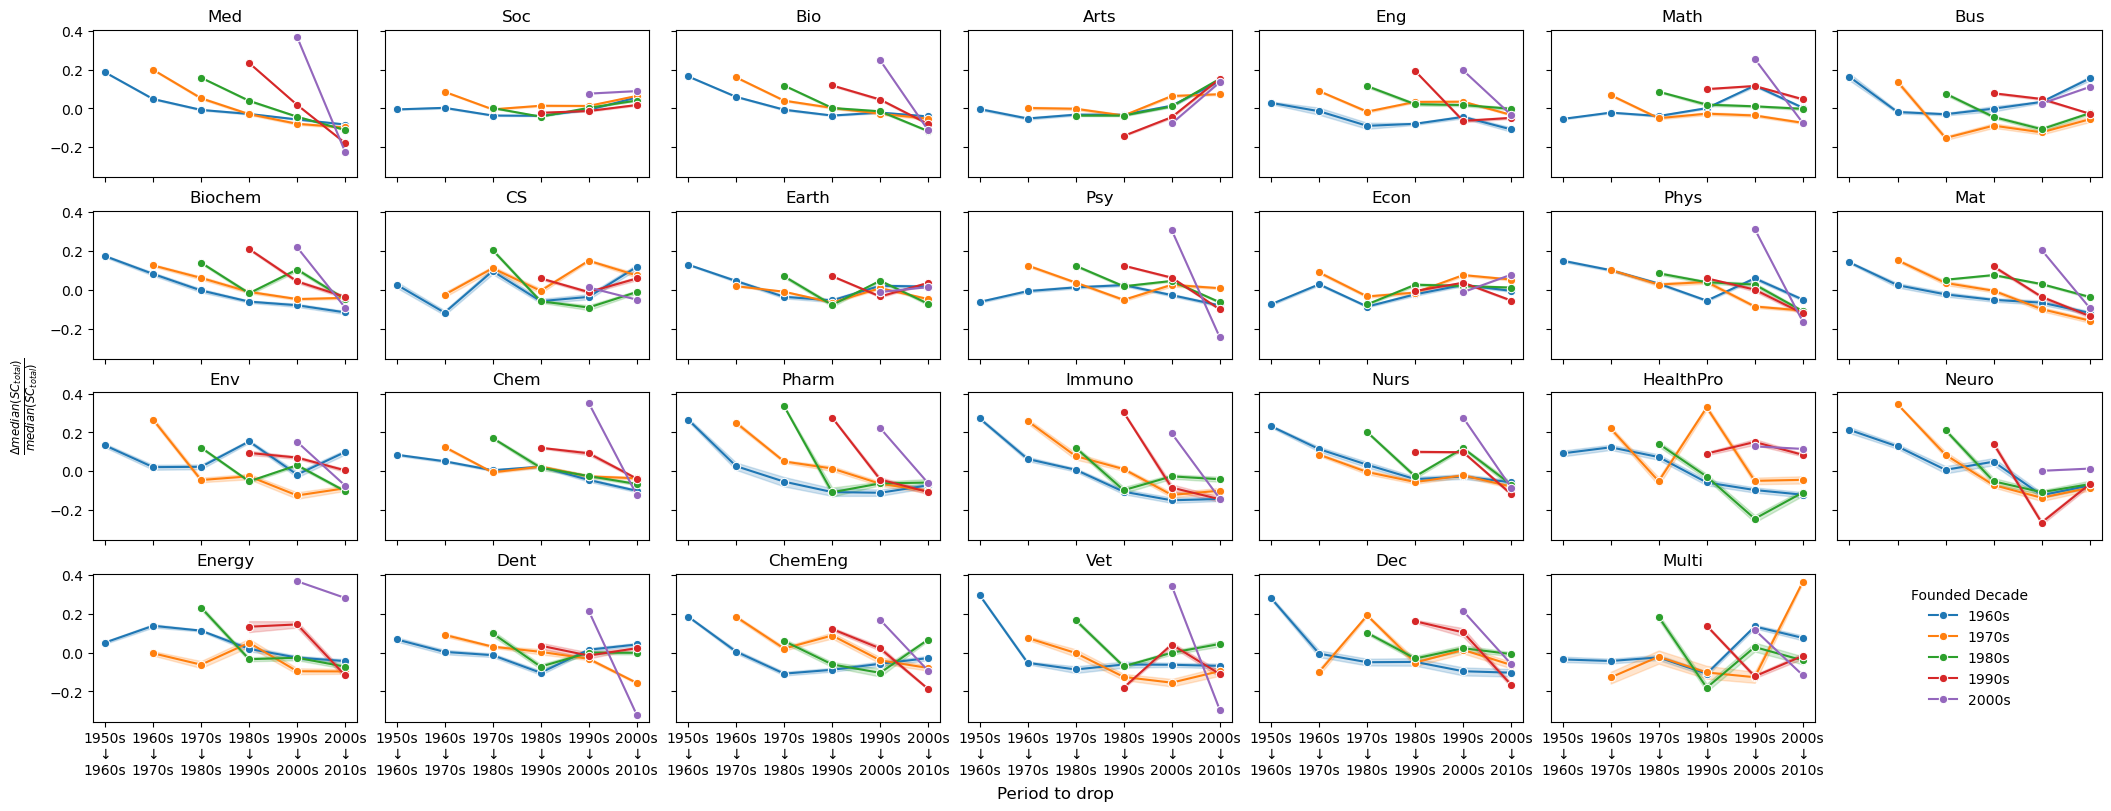

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

plot_df = all_discipline_statistics_df.melt(id_vars=['discipline', 'founded_decade'], 
                    value_vars=['1950_1960', '1960_1970', '1970_1980', '1980_1990', '1990_2000', '2000_2010'],
                    var_name='period', 
                    value_name='value')

plot_df = plot_df.dropna(subset=['value']).explode('value').reset_index(drop=True)
sorted_disciplines = local_semantic_change_df['scopus_label'].value_counts().index.to_list()
ncols = 7
num_disciplines = len(sorted_disciplines)
nrows = math.ceil(num_disciplines / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 2 * nrows), sharex=True, sharey=True, layout='constrained')
axes = axes.flatten()

xticks_v = ['1950s\n↓\n1960s', '1960s\n↓\n1970s', '1970s\n↓\n1980s', '1980s\n↓\n1990s', '1990s\n↓\n2000s', '2000s\n↓\n2010s']

for idx, (ax, discipline) in enumerate(zip(axes, sorted_disciplines)):
    sns.lineplot(data=plot_df[(plot_df['discipline'] == discipline)], 
                 x='period', y='value', hue='founded_decade',
                 ax=ax, marker='o')
    # ax.axhline(0, color='grey', alpha=0.75, linestyle='--', lw=2)
    # ax.set_ylim(-1, 1)
    ax.set_xticks(range(len(xticks_v)))
    ax.set_xticklabels(xticks_v)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().set_visible(False)
    ax.set_title(model.disc2abbr[discipline])

handles, labels = axes[0].get_legend_handles_labels()
axes[-1].legend(handles=handles, labels=labels, title='Founded Decade', loc='center', frameon=False)
axes[-1].axis('off')

fig.supxlabel('Period to drop')
ylabel = metric(get_ylabel=True)
fig.supylabel(ylabel)

plt.show()

### Plot Separately

#### Left

Number of periodicals: 1121


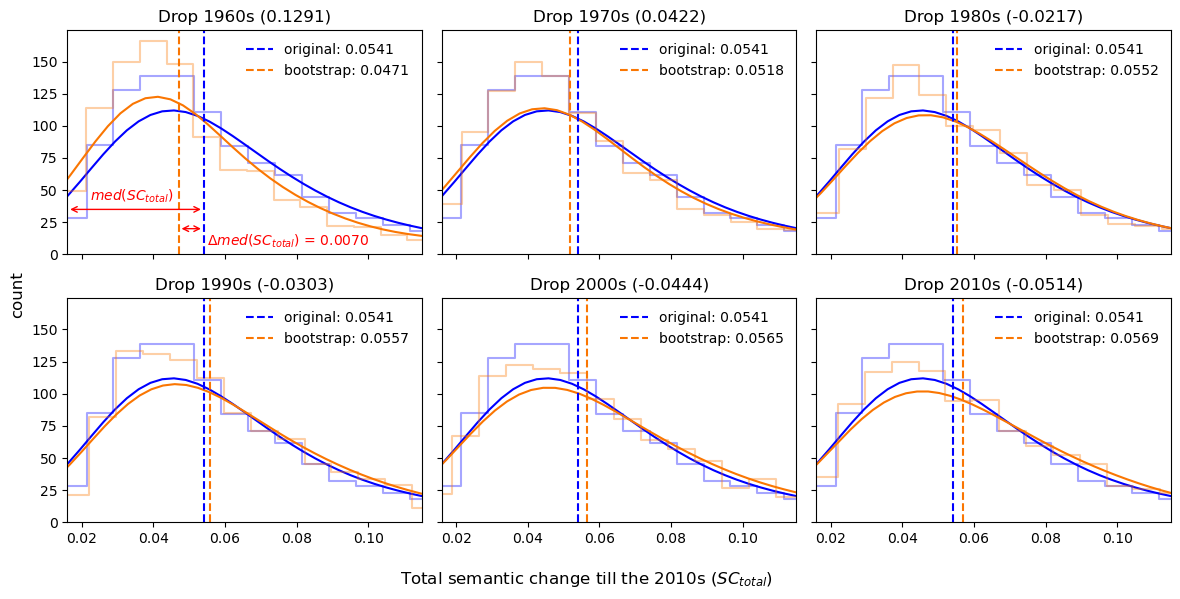

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bootstrap_distributions(start_idx, all_period_mean, xlim):
    found_decade_list = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s']
    period_list = ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
    fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

    # plot distributions period by period
    for i, data in enumerate(all_period_mean[found_decade_list[start_idx]]):
        row, col = divmod(i+start_idx, 3) # calculate row and column index

        sns.histplot(local_semantic_change_df[local_semantic_change_df.start_idx==start_idx].total_semantic_change_2010s, 
                    kde=True, ax=axes[row][col], binwidth=0.0075, alpha=0.35, element="step", color='blue', fill=False)
        sns.histplot(data, kde=True, ax=axes[row][col], binwidth=0.0075, alpha=0.35, element="step", color='#fa7602', fill=False)

        # indicate median value in the histogram
        median_original = local_semantic_change_df[local_semantic_change_df.start_idx==start_idx].total_semantic_change_2010s.median()
        median = np.median(data) 
        axes[row][col].axvline(median_original, color='blue', linestyle='--', label=f'original: {median_original:.4f}')
        axes[row][col].axvline(median, color='#fa7602', linestyle='--', label=f'bootstrap: {median:.4f}') 

        median_diff = median_original - median
        if median_diff > 0.005:
            axes[row][col].annotate('', xy=(median, 20), xytext=(median_original, 20), 
                        arrowprops=dict(arrowstyle="<->", color='red', lw=1))
            axes[row][col].text((median+median_original)/2+0.027, 10, f'$\Delta med(SC_{{total}})$ = {median_diff:.4f}', color='red', ha='center', va='center')
            axes[row][col].annotate('', xy=(xlim[0], 35), xytext=(median_original, 35), 
                        arrowprops=dict(arrowstyle="<->", color='red', lw=1))
            axes[row][col].text((0+median_original)/2+0.007, 45, f'$med(SC_{{total}})$', color='red', ha='center', va='center')
        
        axes[row][col].set_xlim(xlim)

        axes[row][col].set_title(f'Drop {period_list[i+start_idx][-5:]} ({median_diff/median_original:.4f})')
        axes[row][col].set_xlabel('')
        axes[row][col].set_ylabel('')
        axes[row][col].legend(frameon=False)

    print('Number of periodicals:', len(local_semantic_change_df[local_semantic_change_df.start_idx==start_idx]))

    fig.supxlabel('Total semantic change till the 2010s ($SC_{total}$)')
    fig.supylabel('count')

    plt.tight_layout()
    plt.show()

plot_bootstrap_distributions(0, all_period_mean, (0.016, 0.115))

Number of periodicals: 1073


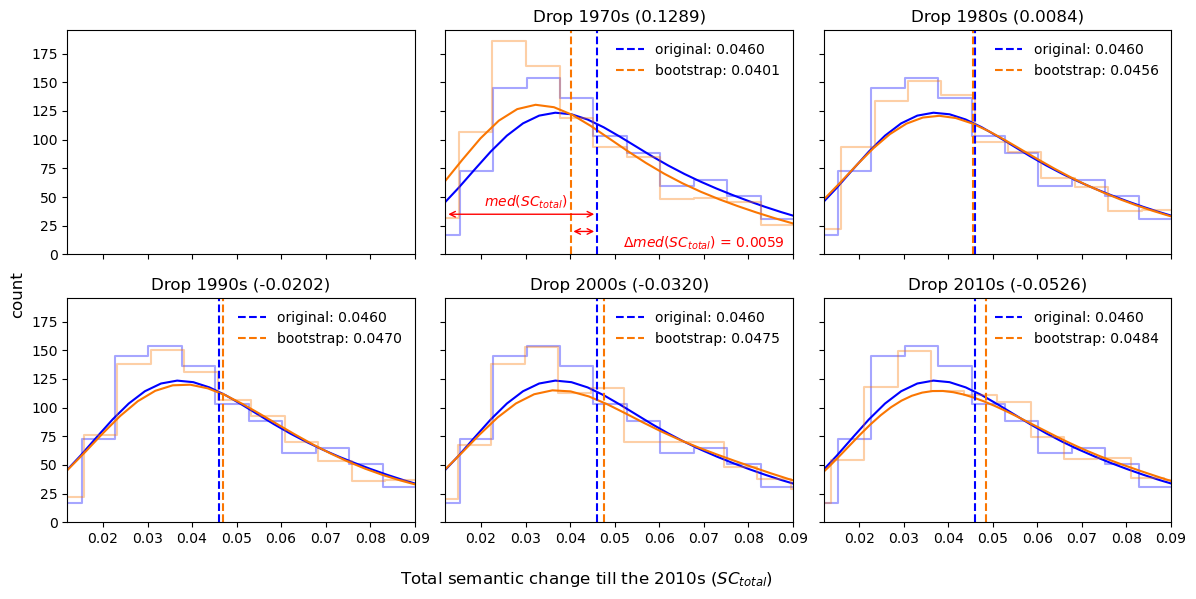

In [13]:
plot_bootstrap_distributions(1, all_period_mean, (0.012, 0.09))

Number of periodicals: 1916


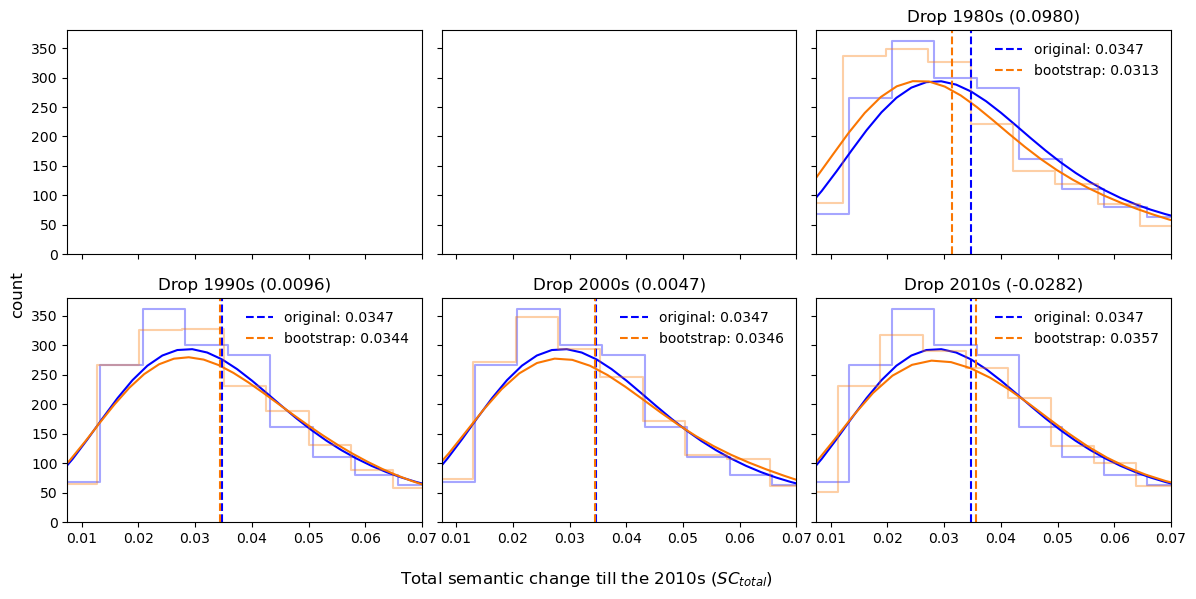

In [14]:
plot_bootstrap_distributions(2, all_period_mean, (0.0075, 0.07))

Number of periodicals: 2959


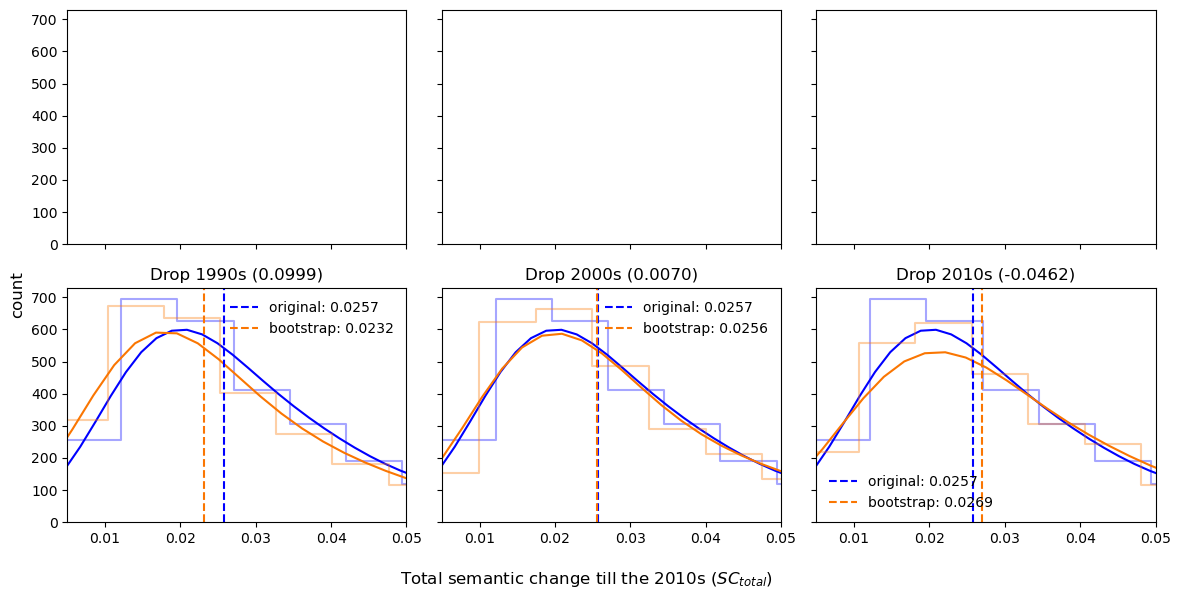

In [16]:
plot_bootstrap_distributions(3, all_period_mean, (0.005, 0.05))

Number of periodicals: 4924


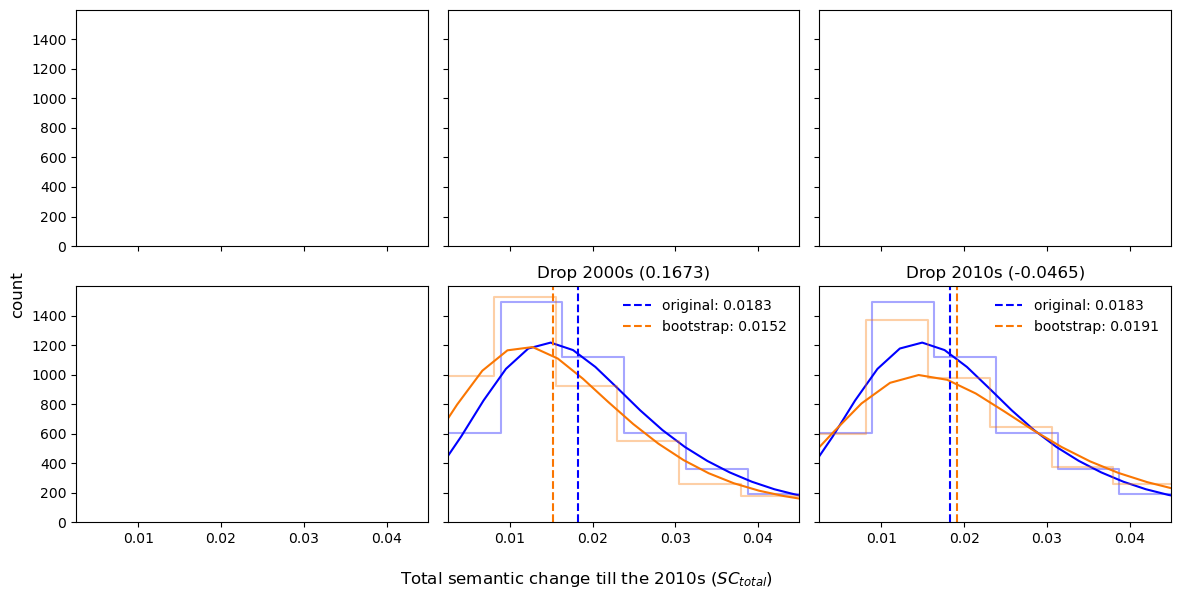

In [17]:
plot_bootstrap_distributions(4, all_period_mean, (0.0025, 0.045))

#### Right

C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_12544\2541400456.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks_v)


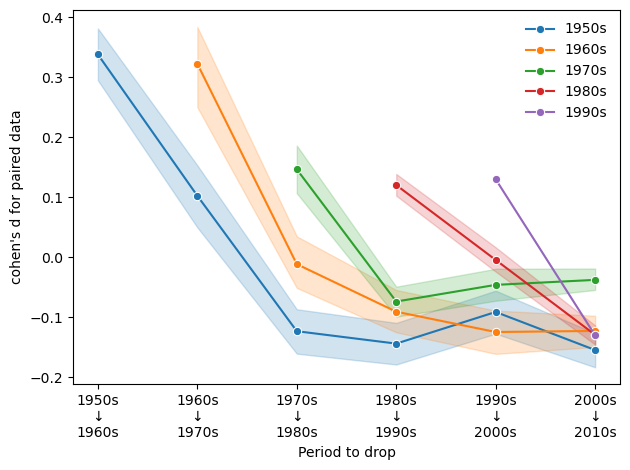

In [17]:
import pandas as pd
plot_data = pd.DataFrame(columns=['Decade', 'Value', 'founded decade'])

for period in ['1950_1960', '1960_1970', '1970_1980', '1980_1990', '1990_2000', '2000_2010']:
    for idx, founded_decade in enumerate(all_age_group_statistics_df['founded decade']):
        if all_age_group_statistics_df[period][idx] is not None:
            temp_df = pd.DataFrame({
                'decade': [period] * len(all_age_group_statistics_df[period][idx]),
                'value': all_age_group_statistics_df[period][idx].flatten(),
                'founded decade': [founded_decade] * len(all_age_group_statistics_df[period][idx])
            })
        plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

plt.figure()
ax = plt.gca()
sns.lineplot(data=plot_data, x='decade', y='value', hue='founded decade', errorbar='pi', marker='o')

xticks_v = ['1950s\n↓\n1960s', '1960s\n↓\n1970s','1970s\n↓\n1980s','1980s\n↓\n1990s','1990s\n↓\n2000s','2000s\n↓\n2010s']
ax.set_xticklabels(xticks_v)
# ax.axhline(0, color='grey', alpha=0.75, linestyle='--', lw=2)

plt.xlabel('Period to drop')
ylabel = metric(get_ylabel=True)
plt.ylabel(ylabel)
plt.legend(frameon=False)
plt.tight_layout()

plt.show()

### Plot togather

C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_31516\52222448.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, temp_df], ignore_index=True)
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_31516\52222448.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(xticks_v)


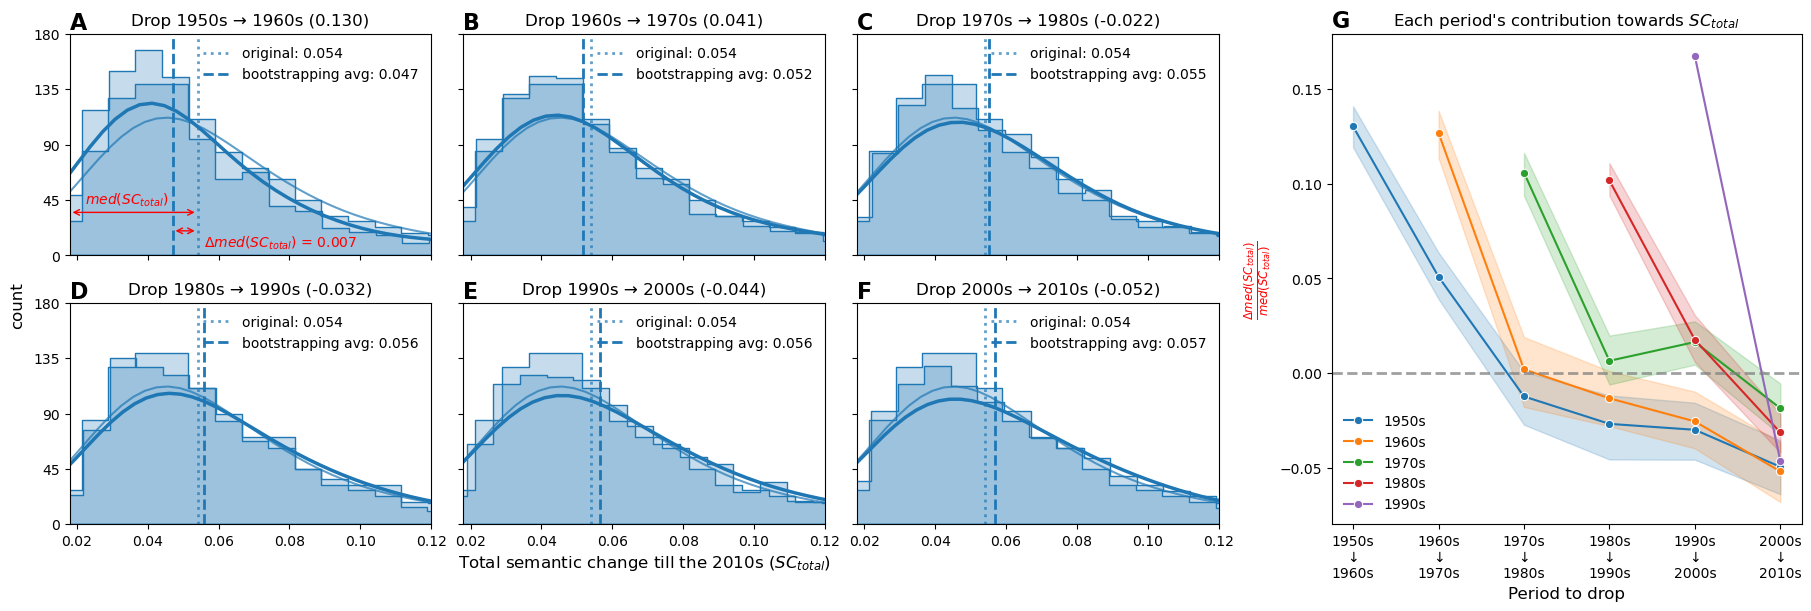

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# creat a figure with 2 rows and 4 columns, the first 3 columns for the first plot, the last column for the second plot
fig1 = plt.figure(figsize=(18, 6), constrained_layout=True)
grid = fig1.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1.3], hspace=0.01, wspace=0.01)  # more space for the second plot

# manully set the y-axis range and ticks
y_min, y_max = 0, 180
yticks = np.linspace(y_min, y_max, 5)

xticks_v = ['1950s\n↓\n1960s', '1960s\n↓\n1970s','1970s\n↓\n1980s','1980s\n↓\n1990s','1990s\n↓\n2000s','2000s\n↓\n2010s']
title_period = ['1950s → 1960s', '1960s → 1970s','1970s → 1980s','1980s → 1990s','1990s → 2000s','2000s → 2010s']

# axes of the first plot
axes = []
panel_labels = ['A', 'B', 'C', 'D', 'E', 'F']  # Define panel labels
for row in range(2):
    for col in range(3):
        ax = fig1.add_subplot(grid[row, col])
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(yticks)
        axes.append(ax)

# the first plot: plot distributions period by period
start_idx = 0
for i, data in enumerate(all_period_mean_list):
    row, col = divmod(i, 3)  # calculate row and column index

    ax = axes[i]
    sns.histplot(local_semantic_change_df[local_semantic_change_df.start_idx == start_idx].total_semantic_change_2010s,
                 kde=True, ax=ax, binwidth=0.0075, alpha=0.25, line_kws={'alpha': 0.7}, element="step", color='#1f77b4', fill=True)
    sns.histplot(data, kde=True, ax=ax, binwidth=0.0075, alpha=0.25, line_kws={'lw': 2.5}, element="step", color='#1f77b4', fill=True)

    # indicate median value in the histogram
    median_original = local_semantic_change_df[local_semantic_change_df.start_idx == start_idx].total_semantic_change_2010s.median()
    median = np.median(data)
    ax.axvline(median_original, color='#1f77b4', alpha=0.7, linestyle='dotted', lw=2, label=f'original: {median_original:.3f}')
    ax.axvline(median, color='#1f77b4', linestyle='--', lw=2, label=f'bootstrapping avg: {median:.3f}')

    median_diff = median_original - median
    if median_diff > 0.005:
        ax.annotate('', xy=(median, 20), xytext=(median_original, 20),
                    arrowprops=dict(arrowstyle="<->", color='red', lw=1))
        ax.text((median + median_original) / 2 + 0.027, 10, f'$\Delta med(SC_{{total}})$ = {median_diff:.3f}', color='red', ha='center', va='center')
        ax.annotate('', xy=(0.018, 35), xytext=(median_original, 35), 
                     arrowprops=dict(arrowstyle="<->", color='red', lw=1))
        ax.text((0+median_original)/2+0.007, 45, f'$med(SC_{{total}})$', color='red', ha='center', va='center')

    # adjust axis labels and ticklabels
    ax.set_ylabel('')
    if row == 1 and col == 1:
        ax.set_xlabel('Total semantic change till the 2010s ($SC_{total}$)', fontsize='larger')
    else:
        ax.set_xlabel('')
    if row != 1:
        ax.set_xticklabels([])
    if col != 0:
        ax.set_yticklabels([])
    
    ax.set_xlim(0.018, 0.12)
    ax.set_title(f'Drop {title_period[i]} ({median_diff/median_original:.3f})')
    ax.legend(frameon=False)

    # Add panel label in the top-left corner of each subplot
    ax.text(-0.0, 1.1, panel_labels[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

# create a super title for the first plot
fig1.supylabel('count')

# the second plot: plot line chart
ax2 = fig1.add_subplot(grid[:, 3])  # the second plot taks the whole last column

plot_data = pd.DataFrame(columns=['Decade', 'Value', 'founded decade'])
for period in ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']:
    for idx, founded_decade in enumerate(all_age_group_result_df['founded decade']):
        if all_age_group_result_df[period][idx] is not None:
            temp_df = pd.DataFrame({
                'Decade': [period] * len(all_age_group_result_df[period][idx]),
                'Value': all_age_group_result_df[period][idx].flatten(),
                'founded decade': [founded_decade] * len(all_age_group_result_df[period][idx])
            })
            plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

sns.lineplot(data=plot_data, x='Decade', y='Value', hue='founded decade', errorbar='pi', marker='o', ax=ax2)
ax2.axhline(0, color='grey', alpha=0.75, linestyle='--', lw=2)

ax2.set_title('Each period\'s contribution towards $SC_{total}$')
ax2.set_xlabel('Period to drop', fontsize='larger')
ax2.set_xticklabels(xticks_v)
ax2.set_ylabel(r'$\frac{\Delta med(SC_{total})}{med(SC_{total})}$', color='red', fontsize='larger')
ax2.legend(frameon=False)

# Add panel label for the second plot
ax2.text(-0.0, 1.05, 'G', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

plt.show()

In [50]:
fig1.savefig('bootstrap.pdf', 
              facecolor='white', 
              transparent=False, 
              bbox_inches='tight')

### If don't bootstraping...

C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_40468\116103945.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks_v)


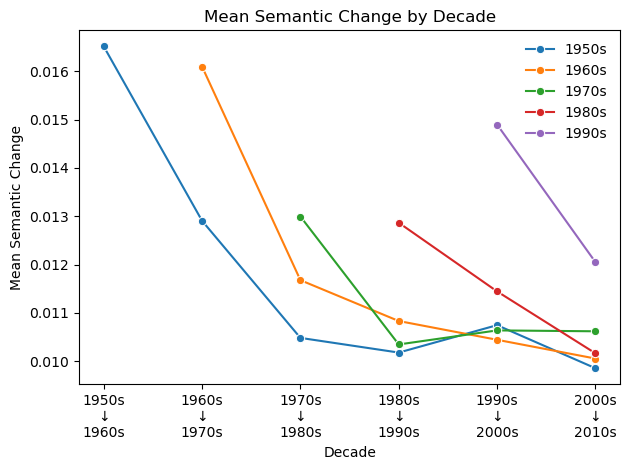

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

decades = ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
plt.figure()

for idx in range(5):
    mean_values = local_semantic_change_df[local_semantic_change_df.start_idx == idx][[
        'semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s',
        'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s'
    ]].mean()
    plot_data = pd.DataFrame({
        'Decade': decades,
        'Mean Semantic Change': mean_values
    })
    sns.lineplot(data=plot_data, x='Decade', y='Mean Semantic Change', marker='o', label=f'{start_year_list[idx]}s')

xticks_v = ['1950s\n↓\n1960s', '1960s\n↓\n1970s','1970s\n↓\n1980s','1980s\n↓\n1990s','1990s\n↓\n2000s','2000s\n↓\n2010s']
ax = plt.gca()
ax.set_xticklabels(xticks_v)
plt.title('Mean Semantic Change by Decade')
plt.legend(frameon=False)
plt.tight_layout()

plt.show()

### If we truncate some points from the oldest periodicals (established in the 1950s)...

In [13]:
import pandas as pd
from tqdm import tqdm

def pad_list_with_none(lst, target_length=6, padding_from: str='left'):
    print('padding length:', target_length - len(lst))
    padding = [None] * (target_length - len(lst))  # generate None list
    if padding_from == 'right':
        return lst + padding  # padding from right
    if padding_from == 'left':
        return padding + lst  # padding from left

def random_replace_per_row(df: pd.DataFrame, column_to_drop: str, remain_columns: list):
    col_to_drop_idx = df.columns.get_loc(column_to_drop)
    # generate a random column index for each row
    num_rows = len(df)
    random_columns_idx = np.random.randint(0, len(remain_columns), size=num_rows)
    # create a 1D array to store candicate values for each row
    replacement_values = df[remain_columns].values[np.arange(num_rows), random_columns_idx]
    df.iloc[:, col_to_drop_idx] = replacement_values
    return df

def measure_period_importance_different_length(local_semantic_change_df, metric):
    from scipy.stats import gaussian_kde
    start_idx = 0 # the age group to be truncated
    period_list = ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 
                   'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
    n_iter = 1000
    all_length_statistic_df = pd.DataFrame(columns=['founded decade', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s'])
    found_decade_list = ['1950s', '1960s', '1970s', '1980s', '1990s']
    all_period_mean = {'1950s': [], '1960s': [], '1970s': [], '1980s': [], '1990s': []} # store the avg of bootstrapping distributions, for plotting 6 subplots on the left

    sampling_df = local_semantic_change_df[local_semantic_change_df.start_idx==start_idx].copy()
    sampling_df.drop(columns=['total_semantic_change_2010s'], inplace=True)

    # for peiodicals established in the 1950s, we cut periods they experienced into 2 parts:
    # 1. kept_period_list
    # 2. truncated_period_list
    # the motivation is to see the impact from the number of points

    for i in range(1, 6): # each truncation generates a new "simulated age group"
        print('truncate at:', i)
        kept_period_list = period_list[:i+1]
        truncated_period_list = period_list[i+1:]
        print('kept period:', kept_period_list)
        print('truncated period:', truncated_period_list)

        # get the original distribution
        original_values = sampling_df[kept_period_list].sum(axis=1).values
        if is_kde_required(metric):
            original_kde = gaussian_kde(original_values)
            x_range = np.linspace(min(original_values), max(original_values), 100)  # 创建网格
            original_pdf = original_kde(x_range)  # 计算原始分布的 PDF
            epsilon = 1e-10
            original_pdf = np.maximum(original_pdf, epsilon)  # 防止零值

        all_period_statistic_list = []
        for period in kept_period_list:
            print('period to drop:', period)
            column_to_drop = period

            remain_columns = kept_period_list.copy()
            remain_columns.remove(period)
            print('remain columns:', remain_columns)

            bootstrap_results = np.zeros((n_iter, len(sampling_df)))  # pre allocate memory
            statistic_results = np.zeros(n_iter)  # shape: (n_iter,)
            print('start iterating...')
            for j in tqdm(range(n_iter), desc='Iterations'):
                replaced_df = random_replace_per_row(sampling_df.copy(), column_to_drop, remain_columns) # make replacement for each row
                bootstrap_values = replaced_df[kept_period_list].sum(axis=1).values
                bootstrap_results[j, :] = bootstrap_values

                if is_kde_required(metric):
                    bootstrap_kde = gaussian_kde(bootstrap_values) # 仅对bootstrap分布计算 KDE
                    bootstrap_pdf = np.maximum(bootstrap_kde(x_range), 1e-10)
                    statistic = metric(original_pdf, bootstrap_pdf)  # 使用原始 PDF 和引导分布 PDF 计算距离
                else:
                    statistic = metric(original_values, bootstrap_values)  # 不使用 KDE，直接使用原始值
                statistic_results[j] = statistic  # store the distance

            print('Mean of statistic:', np.mean(statistic_results))
            all_period_statistic_list.append(statistic_results)
            # store the average of all bootstrap sample, shape: (n_periodicals,), to plot 6 subplots on the left
            all_period_mean[found_decade_list[start_idx]].append(np.mean(bootstrap_results, axis=0))
                
        print('length of generate data:', len(all_period_statistic_list))
        all_period_statistic_list = pad_list_with_none(all_period_statistic_list, padding_from='right')

        # creat a new row and add the new row to the DataFrame
        new_row = pd.DataFrame({
            'founded decade': 'Keep the first '+str(i+1)+' periods',
            '1960s': [all_period_statistic_list[0]],
            '1970s': [all_period_statistic_list[1]],
            '1980s': [all_period_statistic_list[2]],
            '1990s': [all_period_statistic_list[3]],
            '2000s': [all_period_statistic_list[4]],
            '2010s': [all_period_statistic_list[5]]
        })
        all_length_statistic_df = pd.concat([all_length_statistic_df, new_row], ignore_index=True)
        print('\n')
        
    return all_length_statistic_df

In [11]:
metric = median_shifted_ratio

In [16]:
all_length_statistic_df = measure_period_importance_different_length(local_semantic_change_df, metric=metric)

truncate at: 1
kept period: ['semantic_change_1960s', 'semantic_change_1970s']
truncated period: ['semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1387.97it/s]


Mean of statistic: 0.19287729263305664
period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1400.66it/s]


Mean of statistic: -0.031715840101242065
length of generate data: 2
padding length: 4


truncate at: 2
kept period: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s']
truncated period: ['semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1380.22it/s]


Mean of statistic: 0.18552611161768437
period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1385.74it/s]


Mean of statistic: 0.027506316813989542
period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1373.79it/s]


Mean of statistic: -0.08554112490266562
length of generate data: 3
padding length: 3


truncate at: 3
kept period: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s']
truncated period: ['semantic_change_2000s', 'semantic_change_2010s']
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1370.24it/s]


Mean of statistic: 0.16897773164510727
period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1363.01it/s]


Mean of statistic: 0.0330984747922048
period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1327.16it/s]


Mean of statistic: -0.04999267281778157
period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1373.32it/s]


Mean of statistic: -0.07484610434621572
length of generate data: 4
padding length: 2


truncate at: 4
kept period: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
truncated period: ['semantic_change_2010s']
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1381.00it/s]


Mean of statistic: 0.138268838763237
period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1376.12it/s]


Mean of statistic: 0.03901703443331644
period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1351.23it/s]


Mean of statistic: -0.031113943587057293
period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1380.53it/s]


Mean of statistic: -0.05639528436213732
period to drop: semantic_change_2000s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1387.30it/s]


Mean of statistic: -0.04528438772354275
length of generate data: 5
padding length: 1


truncate at: 5
kept period: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
truncated period: []
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1373.64it/s]


Mean of statistic: 0.13033102736622096
period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1370.10it/s]


Mean of statistic: 0.050833480075001714
period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1364.88it/s]


Mean of statistic: -0.01216442001068276
period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1369.39it/s]


Mean of statistic: -0.02678731843805872
period to drop: semantic_change_2000s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1386.88it/s]


Mean of statistic: -0.030157051583752037
period to drop: semantic_change_2010s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1375.80it/s]

Mean of statistic: -0.04964536238647997
length of generate data: 6
padding length: 0




C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_8532\3710680918.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, temp_df], ignore_index=True)
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_8532\3710680918.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks_v)


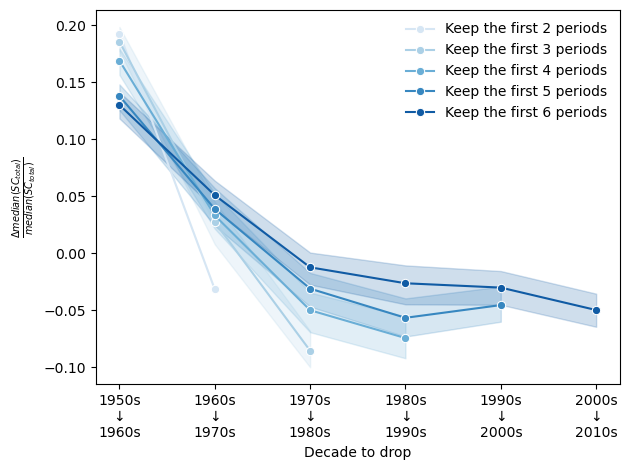

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = pd.DataFrame(columns=['Decade', 'Value', 'founded decade'])
for idx, founded_decade in enumerate(all_length_statistic_df['founded decade']):
    for period in ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']:
        if all_length_statistic_df[period][idx] is not None:
            temp_df = pd.DataFrame({
                'Decade': [period] * len(all_length_statistic_df[period][idx]),
                'Value': all_length_statistic_df[period][idx].flatten(),
                'founded decade': [founded_decade] * len(all_length_statistic_df[period][idx])
            })
            plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

plt.figure()
sns.lineplot(data=plot_data, x='Decade', y='Value', hue='founded decade', palette='Blues', errorbar='pi', marker='o')
ax = plt.gca()
xticks_v = ['1950s\n↓\n1960s', '1960s\n↓\n1970s','1970s\n↓\n1980s','1980s\n↓\n1990s','1990s\n↓\n2000s','2000s\n↓\n2010s']
ax.set_xticklabels(xticks_v)
# ax.axhline(0, color='grey', alpha=0.75, linestyle='--', lw=2)

plt.xlabel('Decade to drop')
# ax.set_ylim(-0.1, 0.55)
ylabel = metric(get_ylabel=True)
plt.ylabel(ylabel)

plt.legend(frameon=False)
plt.tight_layout()
plt.show()

### Keep all series in the same length

In [12]:
import pandas as pd
from tqdm import tqdm

def tailor_semantic_change_df(df: pd.DataFrame, length: int):
    '''
    Tailor the SC series, only keep the first n semantic changes for each row, where n is the length.
    '''
    semantic_change_list = ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 
                            'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
    result_rows = []

    def process_row(row):
        start_idx = row['start_idx']
        selected_columns = semantic_change_list[start_idx:start_idx + length]

        selected_data = row[selected_columns]
        
        if selected_data.notna().sum() >= length: # drop the row if the number of non-NaN values is less than the length
            selected_data.index = range(1, length + 1)
            selected_data_with_idx = pd.concat([selected_data, pd.Series({'start_idx': start_idx})])
            result_rows.append(selected_data_with_idx)

    df.apply(process_row, axis=1)

    tailored_df = pd.DataFrame(result_rows, columns=list(range(1, length + 1)) + ['start_idx'])
    return tailored_df

In [16]:
def random_replace_per_row(df: pd.DataFrame, column_to_drop: str, remain_columns: list):
    col_to_drop_idx = df.columns.get_loc(column_to_drop)
    # generate a random column index for each row
    num_rows = len(df)
    random_columns_idx = np.random.randint(0, len(remain_columns), size=num_rows)
    # create a 1D array to store candicate values for each row
    replacement_values = df[remain_columns].values[np.arange(num_rows), random_columns_idx]
    df.iloc[:, col_to_drop_idx] = replacement_values
    return df

def measure_period_importance_different_length_all_age_droup(local_semantic_change_df, metric, discpline=None):
    from scipy.stats import gaussian_kde
    start_year_list = [1950, 1960, 1970, 1980, 1990]

    length_list = [2, 3, 4, 5, 6]
    start_idxs = [0, 1, 2, 3, 4]
    n_iter = 1000

    all_length_result_list = []
    for length in length_list:
        print('Tailoring semantic change series into length:', length, '...')
        print('For this length, only consider periodicals established in', 
            [str(start_year_list[start_idx])+'s' for start_idx in start_idxs[:len(start_idxs) - (length - 2)]])
        if discpline is not None:
            tailored_df = tailor_semantic_change_df(local_semantic_change_df[local_semantic_change_df.scopus_label == discpline], length)
        else:
            tailored_df = tailor_semantic_change_df(local_semantic_change_df, length)
        print('Finish tailoring. Number of periodicals:', len(tailored_df), '\n')

        columns = ['founded decade'] + [i + 1 for i in range(length)] # generate columns names according to the length
        all_age_group_result_df = pd.DataFrame(columns=columns)

        for start_idx in start_idxs[:len(start_idxs) - (length - 2)]:
            sampling_df = tailored_df[tailored_df.start_idx==start_idx].copy()
            # get the original distribution
            original_values = sampling_df[list(range(1, length+1))].sum(axis=1).values
            if is_kde_required(metric):
                original_kde = gaussian_kde(original_values)
                x_range = np.linspace(min(original_values), max(original_values), 100)  # make a grid for KDE
                original_pdf = original_kde(x_range)  # 计算原始分布的 PDF
                epsilon = 1e-10
                original_pdf = np.maximum(original_pdf, epsilon)  # 防止零值
            print(f'processing {len(sampling_df)} periodicals established in {start_year_list[start_idx]}s')
            print(f'current length: {length}')

            all_period_statistic_list = []
            for period in range(1, length+1):
                print('period to drop:', period)
                column_to_drop = period
                change_df = sampling_df.copy()
                remain_columns = list(range(1, length+1))
                remain_columns.remove(period)
                print('remain columns:', remain_columns)

                bootstrap_results = np.zeros((n_iter, len(change_df)))  # pre allocate memory, median of all periodials, shape: (n_iter, n_periodicals)
                statistic_results = np.zeros(n_iter)  # shape: (n_iter,)
                print('start iterating...')
                for j in tqdm(range(n_iter), desc='Iterations'):
                    replaced_df = random_replace_per_row(change_df.copy(), column_to_drop, remain_columns) # make replacement for each row
                    bootstrap_values = replaced_df[list(range(1, length+1))].sum(axis=1).values
                    bootstrap_results[j, :] = bootstrap_values

                    if is_kde_required(metric):
                        bootstrap_kde = gaussian_kde(bootstrap_values) # 仅对bootstrap分布计算 KDE
                        bootstrap_pdf = np.maximum(bootstrap_kde(x_range), 1e-10)
                        statistic = metric(original_pdf, bootstrap_pdf)  # 使用原始 PDF 和引导分布 PDF 计算距离
                    else:
                        statistic = metric(original_values, bootstrap_values)  # 不使用 KDE，直接使用原始值
                    statistic_results[j] = statistic  # store the distance

                print('mean of statistic:', np.mean(statistic_results))
                all_period_statistic_list.append(statistic_results)
                    
            print('length of generate data:', len(all_period_statistic_list))

            new_row_data = { # a dict to store the new row data
                'founded decade': [str(start_year_list[start_idx]) + 's']
            }
            for k in range(length): # add new keys: 1, 2, ...
                new_row_data[k + 1] = [all_period_statistic_list[k]]
            new_row = pd.DataFrame(new_row_data)
            all_age_group_result_df = pd.concat([all_age_group_result_df, new_row], ignore_index=True)
        all_length_result_list.append(all_age_group_result_df)
        print('Finish processing length:', length, '\n')

    return all_length_result_list

In [14]:
metric = median_shifted_ratio

In [17]:
all_length_result_list = measure_period_importance_different_length_all_age_droup(local_semantic_change_df, discpline=None, 
                                                                                  metric=metric)

Tailoring semantic change series into length: 2 ...
For this length, only consider periodicals established in ['1950s', '1960s', '1970s', '1980s', '1990s']
Finish tailoring. Number of periodicals: 11993 

processing 1121 periodicals established in 1950s
current length: 2
period to drop: 1
remain columns: [2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1167.61it/s]


mean of statistic: 0.19287726298638305
period to drop: 2
remain columns: [1]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1118.42it/s]


mean of statistic: -0.03171587892266209
length of generate data: 2
processing 1073 periodicals established in 1960s
current length: 2
period to drop: 1
remain columns: [2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1165.13it/s]


mean of statistic: 0.23051371469033735
period to drop: 2
remain columns: [1]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1169.33it/s]


mean of statistic: -0.11207036385077383
length of generate data: 2
processing 1916 periodicals established in 1970s
current length: 2
period to drop: 1
remain columns: [2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1055.72it/s]


mean of statistic: 0.17035288169992088
period to drop: 2
remain columns: [1]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1028.76it/s]


mean of statistic: -0.04571409512032333
length of generate data: 2
processing 2959 periodicals established in 1980s
current length: 2
period to drop: 1
remain columns: [2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:01<00:00, 965.21it/s]


mean of statistic: 0.12298619590682341
period to drop: 2
remain columns: [1]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:01<00:00, 965.15it/s]


mean of statistic: 0.003874314147365943
length of generate data: 2
processing 4924 periodicals established in 1990s
current length: 2
period to drop: 1
remain columns: [2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:01<00:00, 800.20it/s]


mean of statistic: 0.16729841092120257
period to drop: 2
remain columns: [1]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:01<00:00, 803.06it/s]


mean of statistic: -0.04645224867123476
length of generate data: 2
Finish processing length: 2 

Tailoring semantic change series into length: 3 ...
For this length, only consider periodicals established in ['1950s', '1960s', '1970s', '1980s']
Finish tailoring. Number of periodicals: 7069 

processing 1121 periodicals established in 1950s
current length: 3
period to drop: 1
remain columns: [2, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1168.51it/s]


mean of statistic: 0.18587815144030015
period to drop: 2
remain columns: [1, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1106.55it/s]


mean of statistic: 0.027787734553025713
period to drop: 3
remain columns: [1, 2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1142.78it/s]


mean of statistic: -0.08584542440237738
length of generate data: 3
processing 1073 periodicals established in 1960s
current length: 3
period to drop: 1
remain columns: [2, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1158.88it/s]


mean of statistic: 0.18061547458295577
period to drop: 2
remain columns: [1, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1152.35it/s]


mean of statistic: -0.023280739615779894
period to drop: 3
remain columns: [1, 2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1153.47it/s]


mean of statistic: -0.04150351900012436
length of generate data: 3
processing 1916 periodicals established in 1970s
current length: 3
period to drop: 1
remain columns: [2, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1036.88it/s]


mean of statistic: 0.12506045192525309
period to drop: 2
remain columns: [1, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1042.10it/s]


mean of statistic: 0.0015098543107333073
period to drop: 3
remain columns: [1, 2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1028.38it/s]


mean of statistic: 0.007039235155540531
length of generate data: 3
processing 2959 periodicals established in 1980s
current length: 3
period to drop: 1
remain columns: [2, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:01<00:00, 924.41it/s]


mean of statistic: 0.10206168521088183
period to drop: 2
remain columns: [1, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:01<00:00, 938.62it/s]


mean of statistic: 0.01788877542983238
period to drop: 3
remain columns: [1, 2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:01<00:00, 930.03it/s]


mean of statistic: -0.031276972935447275
length of generate data: 3
Finish processing length: 3 

Tailoring semantic change series into length: 4 ...
For this length, only consider periodicals established in ['1950s', '1960s', '1970s']
Finish tailoring. Number of periodicals: 4110 

processing 1121 periodicals established in 1950s
current length: 4
period to drop: 1
remain columns: [2, 3, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1155.59it/s]


mean of statistic: 0.1691889390712497
period to drop: 2
remain columns: [1, 3, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1124.58it/s]


mean of statistic: 0.03308750422606207
period to drop: 3
remain columns: [1, 2, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1109.59it/s]


mean of statistic: -0.04959452023625717
period to drop: 4
remain columns: [1, 2, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1115.55it/s]


mean of statistic: -0.07490689247883595
length of generate data: 4
processing 1073 periodicals established in 1960s
current length: 4
period to drop: 1
remain columns: [2, 3, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1140.84it/s]


mean of statistic: 0.1409522223715551
period to drop: 2
remain columns: [1, 3, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1018.15it/s]


mean of statistic: -0.011187965180387624
period to drop: 3
remain columns: [1, 2, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1130.47it/s]


mean of statistic: -0.029092129759324157
period to drop: 4
remain columns: [1, 2, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1145.40it/s]


mean of statistic: -0.03810728933835328
length of generate data: 4
processing 1916 periodicals established in 1970s
current length: 4
period to drop: 1
remain columns: [2, 3, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1019.84it/s]


mean of statistic: 0.10610144540314198
period to drop: 2
remain columns: [1, 3, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1009.37it/s]


mean of statistic: 0.006498639306436247
period to drop: 3
remain columns: [1, 2, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1011.78it/s]


mean of statistic: 0.016642606933163794
period to drop: 4
remain columns: [1, 2, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1016.40it/s]


mean of statistic: -0.018890105611007495
length of generate data: 4
Finish processing length: 4 

Tailoring semantic change series into length: 5 ...
For this length, only consider periodicals established in ['1950s', '1960s']
Finish tailoring. Number of periodicals: 2194 

processing 1121 periodicals established in 1950s
current length: 5
period to drop: 1
remain columns: [2, 3, 4, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:01<00:00, 932.57it/s]


mean of statistic: 0.13798423414733604
period to drop: 2
remain columns: [1, 3, 4, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:01<00:00, 919.84it/s]


mean of statistic: 0.03838409878417926
period to drop: 3
remain columns: [1, 2, 4, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1130.29it/s]


mean of statistic: -0.03087817220781984
period to drop: 4
remain columns: [1, 2, 3, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1109.70it/s]


mean of statistic: -0.056512990882882856
period to drop: 5
remain columns: [1, 2, 3, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1119.89it/s]


mean of statistic: -0.045447172693284674
length of generate data: 5
processing 1073 periodicals established in 1960s
current length: 5
period to drop: 1
remain columns: [2, 3, 4, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1147.76it/s]


mean of statistic: 0.12723010653412659
period to drop: 2
remain columns: [1, 3, 4, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1124.17it/s]


mean of statistic: 0.002639122492347459
period to drop: 3
remain columns: [1, 2, 4, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1145.25it/s]


mean of statistic: -0.013756934490297955
period to drop: 4
remain columns: [1, 2, 3, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1120.35it/s]


mean of statistic: -0.02569921205649539
period to drop: 5
remain columns: [1, 2, 3, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1133.66it/s]


mean of statistic: -0.052179494981197845
length of generate data: 5
Finish processing length: 5 

Tailoring semantic change series into length: 6 ...
For this length, only consider periodicals established in ['1950s']
Finish tailoring. Number of periodicals: 1121 

processing 1121 periodicals established in 1950s
current length: 6
period to drop: 1
remain columns: [2, 3, 4, 5, 6]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1036.87it/s]


mean of statistic: 0.13050373413584676
period to drop: 2
remain columns: [1, 3, 4, 5, 6]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1055.69it/s]


mean of statistic: 0.05106492202084711
period to drop: 3
remain columns: [1, 2, 4, 5, 6]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1077.11it/s]


mean of statistic: -0.012216637865290255
period to drop: 4
remain columns: [1, 2, 3, 5, 6]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1066.53it/s]


mean of statistic: -0.02673797674720395
period to drop: 5
remain columns: [1, 2, 3, 4, 6]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1102.24it/s]


mean of statistic: -0.02988812104020095
period to drop: 6
remain columns: [1, 2, 3, 4, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1102.95it/s]

mean of statistic: -0.05042631615467787
length of generate data: 6
Finish processing length: 6 



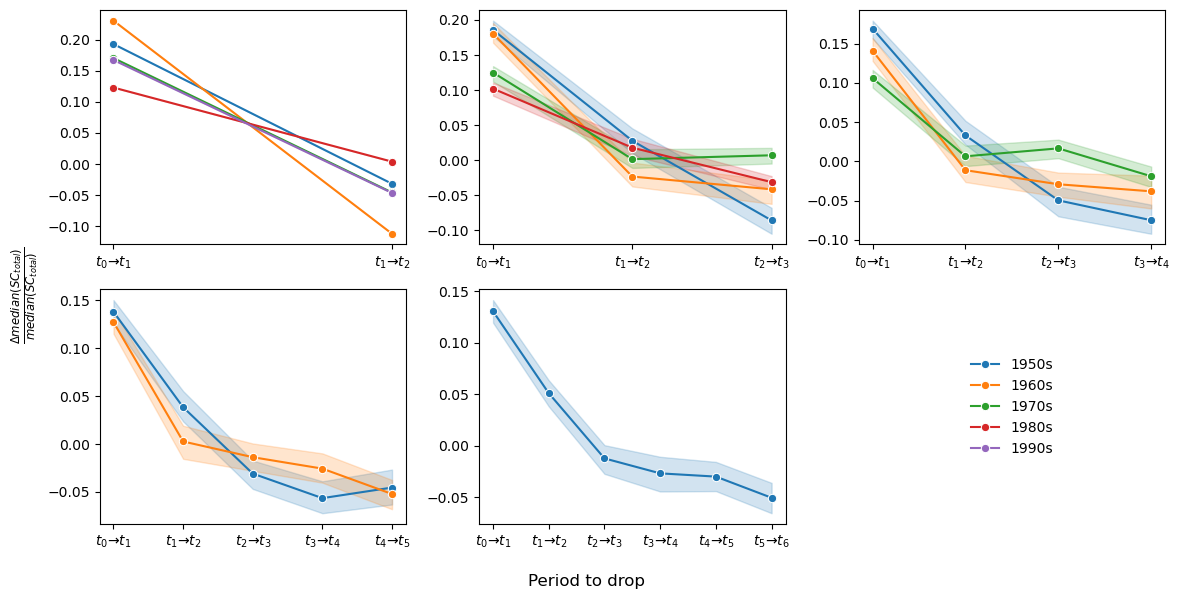

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))

age_groups = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
length_list = [2, 3, 4, 5, 6]

for idx, all_age_group_result_df in enumerate(all_length_result_list):
    length = length_list[idx]
    df_exploded = all_age_group_result_df.explode(list(range(1, length+1)))
    df_long = pd.melt(df_exploded, id_vars=['founded decade'], value_vars=list(range(1, length+1)),
                      var_name='Decades elapsed', value_name='value')

    ax = fig.add_subplot(2,3, idx+1)

    sns.lineplot(data=df_long, x='Decades elapsed', y='value', hue='founded decade', errorbar='pi', marker='o')
    # ax.axhline(0, color='grey', alpha=0.75, linestyle='--', lw=2)
    plt.xticks(range(1, length+1), [fr'$t_{num-1}$'+'→'+fr'$t_{num}$' for num in range(1, length+1)])
    plt.xlabel('')
    plt.ylabel('')
    ax.legend().set_visible(False)
    if idx == 0:
        handles, labels = ax.get_legend_handles_labels()

if handles and labels:
    ax = fig.add_subplot(2, 3, 6)
    ax.set_axis_off()
    ax.legend(handles=handles, labels=labels, loc='center',
              frameon=False)

fig.supxlabel('Period to drop')
ylabel = metric(get_ylabel=True)
fig.supylabel(ylabel)

plt.tight_layout()
plt.show()

### Just check Multidisciplinary Periodicals

In [35]:
all_length_statistic_df = measure_period_importance_different_length(local_semantic_change_df[local_semantic_change_df.scopus_label=='Multidisciplinary'], metric=cohens_d)

truncate at: 1
kept period: ['semantic_change_1960s', 'semantic_change_1970s']
truncated period: ['semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1610.84it/s]


Mean of statistic: 0.45151928092611027
period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1661.04it/s]


Mean of statistic: -0.22369104231037296
length of generate data: 2
padding length: 4


truncate at: 2
kept period: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s']
truncated period: ['semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1661.04it/s]


Mean of statistic: 0.391682211975525
period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1675.35it/s]


Mean of statistic: -0.09373906797379135
period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1649.99it/s]


Mean of statistic: -0.12064858450353268
length of generate data: 3
padding length: 3


truncate at: 3
kept period: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s']
truncated period: ['semantic_change_2000s', 'semantic_change_2010s']
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1683.54it/s]


Mean of statistic: 0.3163240343414827
period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1661.50it/s]


Mean of statistic: -0.05060391962217002
period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1630.79it/s]


Mean of statistic: -0.07878169633386732
period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1689.79it/s]


Mean of statistic: -0.06759389512138364
length of generate data: 4
padding length: 2


truncate at: 4
kept period: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
truncated period: ['semantic_change_2010s']
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1650.03it/s]


Mean of statistic: 0.23187838923232754
period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1620.13it/s]


Mean of statistic: -0.05207966535441282
period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1615.42it/s]


Mean of statistic: -0.07904840303716336
period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1673.92it/s]


Mean of statistic: -0.07449136936725008
period to drop: semantic_change_2000s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1679.87it/s]


Mean of statistic: 0.05891868929285988
length of generate data: 5
padding length: 1


truncate at: 5
kept period: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
truncated period: []
period to drop: semantic_change_1960s
remain columns: ['semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1652.09it/s]


Mean of statistic: 0.1611345827316575
period to drop: semantic_change_1970s
remain columns: ['semantic_change_1960s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1649.25it/s]


Mean of statistic: -0.06207266054818523
period to drop: semantic_change_1980s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1651.87it/s]


Mean of statistic: -0.08132162057502185
period to drop: semantic_change_1990s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_2000s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1699.30it/s]


Mean of statistic: -0.07589516129951031
period to drop: semantic_change_2000s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2010s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1676.36it/s]


Mean of statistic: 0.030799576457839324
period to drop: semantic_change_2010s
remain columns: ['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s']
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1627.82it/s]

Mean of statistic: 0.07631474529481236
length of generate data: 6
padding length: 0




C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\2228710463.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, temp_df], ignore_index=True)
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\2228710463.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks_v)


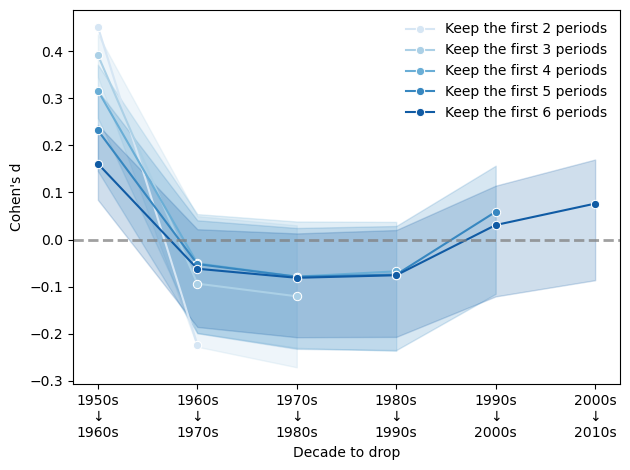

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = pd.DataFrame(columns=['Decade', 'Value', 'founded decade'])
for idx, founded_decade in enumerate(all_length_statistic_df['founded decade']):
    for period in ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']:
        if all_length_statistic_df[period][idx] is not None:
            temp_df = pd.DataFrame({
                'Decade': [period] * len(all_length_statistic_df[period][idx]),
                'Value': all_length_statistic_df[period][idx].flatten(),
                'founded decade': [founded_decade] * len(all_length_statistic_df[period][idx])
            })
            plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

plt.figure()
sns.lineplot(data=plot_data, x='Decade', y='Value', hue='founded decade', palette='Blues', errorbar='pi', marker='o')
ax = plt.gca()
xticks_v = ['1950s\n↓\n1960s', '1960s\n↓\n1970s','1970s\n↓\n1980s','1980s\n↓\n1990s','1990s\n↓\n2000s','2000s\n↓\n2010s']
ax.set_xticklabels(xticks_v)
ax.axhline(0, color='grey', alpha=0.75, linestyle='--', lw=2)

plt.xlabel('Decade to drop')
# ax.set_ylim(-0.1, 0.55)
plt.ylabel('Cohen\'s d')

plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [32]:
all_length_result_list = measure_period_importance_different_length_all_age_droup(local_semantic_change_df[local_semantic_change_df.scopus_label=='Multidisciplinary'], metric=cohens_d)

Tailoring semantic change series into length: 2 ...
For this length, only consider periodicals established in ['1950s', '1960s', '1970s', '1980s', '1990s']
Finish tailoring. Number of periodicals: 22 

processing 7 periodicals established in 1950s
current length: 2
period to drop: 1
remain columns: [2]
start iterating...


Iterations:  14%|█▍        | 141/1000 [00:00<00:00, 1407.00it/s]

Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1330.19it/s]


mean of Distance: 0.45151937793427444
period to drop: 2
remain columns: [1]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1535.72it/s]


mean of Distance: -0.22369103830777923
length of generate data: 2


processing 1 periodicals established in 1960s
current length: 2
period to drop: 1
remain columns: [2]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: -inf
period to drop: 2
remain columns: [1]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: inf
length of generate data: 2


processing 4 periodicals established in 1970s
current length: 2
period to drop: 1
remain columns: [2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1516.77it/s]


mean of Distance: 0.6225939887374512
period to drop: 2
remain columns: [1]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1527.03it/s]


mean of Distance: -0.4135995178613045
length of generate data: 2


processing 2 periodicals established in 1980s
current length: 2
period to drop: 1
remain columns: [2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1507.39it/s]


mean of Distance: 1.0981956544570006
period to drop: 2
remain columns: [1]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1498.00it/s]


mean of Distance: -2.522706665105465
length of generate data: 2


processing 8 periodicals established in 1990s
current length: 2
period to drop: 1
remain columns: [2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1493.12it/s]


mean of Distance: 0.5280390260782024
period to drop: 2
remain columns: [1]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1506.05it/s]


mean of Distance: -0.33517723784811404
length of generate data: 2


Finish processing length: 2 

Tailoring semantic change series into length: 3 ...
For this length, only consider periodicals established in ['1950s', '1960s', '1970s', '1980s']
Finish tailoring. Number of periodicals: 14 

processing 7 periodicals established in 1950s
current length: 3
period to drop: 1
remain columns: [2, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1487.90it/s]


mean of Distance: 0.3913893179335686
period to drop: 2
remain columns: [1, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1497.97it/s]


mean of Distance: -0.09868555725647414
period to drop: 3
remain columns: [1, 2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1503.71it/s]


mean of Distance: -0.12231687813918798
length of generate data: 3


processing 1 periodicals established in 1960s
current length: 3
period to drop: 1
remain columns: [2, 3]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: -inf
period to drop: 2
remain columns: [1, 3]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: inf
period to drop: 3
remain columns: [1, 2]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: nan
length of generate data: 3


processing 4 periodicals established in 1970s
current length: 3
period to drop: 1
remain columns: [2, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1498.70it/s]


mean of Distance: 0.35851565693238946
period to drop: 2
remain columns: [1, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1512.87it/s]


mean of Distance: -0.21674883498220843
period to drop: 3
remain columns: [1, 2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1522.11it/s]


mean of Distance: -0.06065932950143676
length of generate data: 3


processing 2 periodicals established in 1980s
current length: 3
period to drop: 1
remain columns: [2, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1455.49it/s]


mean of Distance: 0.6607528461620438
period to drop: 2
remain columns: [1, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1486.52it/s]


mean of Distance: -1.2686534798646376
period to drop: 3
remain columns: [1, 2]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1535.18it/s]


mean of Distance: -0.20803093336025838
length of generate data: 3


Finish processing length: 3 

Tailoring semantic change series into length: 4 ...
For this length, only consider periodicals established in ['1950s', '1960s', '1970s']
Finish tailoring. Number of periodicals: 12 

processing 7 periodicals established in 1950s
current length: 4
period to drop: 1
remain columns: [2, 3, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1542.11it/s]


mean of Distance: 0.31693361896344074
period to drop: 2
remain columns: [1, 3, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1527.27it/s]


mean of Distance: -0.05274563306339155
period to drop: 3
remain columns: [1, 2, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1501.98it/s]


mean of Distance: -0.0749801489007564
period to drop: 4
remain columns: [1, 2, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1533.09it/s]


mean of Distance: -0.07501478867330533
length of generate data: 4


processing 1 periodicals established in 1960s
current length: 4
period to drop: 1
remain columns: [2, 3, 4]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: -inf
period to drop: 2
remain columns: [1, 3, 4]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: inf
period to drop: 3
remain columns: [1, 2, 4]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: nan
period to drop: 4
remain columns: [1, 2, 3]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: nan
length of generate data: 4


processing 4 periodicals established in 1970s
current length: 4
period to drop: 1
remain columns: [2, 3, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1525.03it/s]


mean of Distance: 0.20430536946953773
period to drop: 2
remain columns: [1, 3, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1517.56it/s]


mean of Distance: -0.16037841241352094
period to drop: 3
remain columns: [1, 2, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1501.15it/s]


mean of Distance: -0.05815474175736447
period to drop: 4
remain columns: [1, 2, 3]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1472.41it/s]


mean of Distance: 0.050632099488344184
length of generate data: 4


Finish processing length: 4 

Tailoring semantic change series into length: 5 ...
For this length, only consider periodicals established in ['1950s', '1960s']
Finish tailoring. Number of periodicals: 8 

processing 7 periodicals established in 1950s
current length: 5
period to drop: 1
remain columns: [2, 3, 4, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1513.88it/s]


mean of Distance: 0.231083899551513
period to drop: 2
remain columns: [1, 3, 4, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1434.05it/s]


mean of Distance: -0.05604795938664132
period to drop: 3
remain columns: [1, 2, 4, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1544.26it/s]


mean of Distance: -0.07781955396932483
period to drop: 4
remain columns: [1, 2, 3, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1522.06it/s]


mean of Distance: -0.07892723011706085
period to drop: 5
remain columns: [1, 2, 3, 4]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1499.90it/s]


mean of Distance: 0.057769183988617544
length of generate data: 5


processing 1 periodicals established in 1960s
current length: 5
period to drop: 1
remain columns: [2, 3, 4, 5]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: -inf
period to drop: 2
remain columns: [1, 3, 4, 5]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: nan
period to drop: 3
remain columns: [1, 2, 4, 5]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: nan
period to drop: 4
remain columns: [1, 2, 3, 5]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: nan
period to drop: 5
remain columns: [1, 2, 3, 4]
start iterating...


Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return diff_mean / pooled_std
C:\Users\lyuzhuoqi\AppData\Local\Temp\ipykernel_54788\581704121.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  

mean of Distance: inf
length of generate data: 5


Finish processing length: 5 

Tailoring semantic change series into length: 6 ...
For this length, only consider periodicals established in ['1950s']
Finish tailoring. Number of periodicals: 7 

processing 7 periodicals established in 1950s
current length: 6
period to drop: 1
remain columns: [2, 3, 4, 5, 6]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1502.22it/s]


mean of Distance: 0.15963259297660562
period to drop: 2
remain columns: [1, 3, 4, 5, 6]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1515.02it/s]


mean of Distance: -0.05846350427513191
period to drop: 3
remain columns: [1, 2, 4, 5, 6]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1511.01it/s]


mean of Distance: -0.08007447867600487
period to drop: 4
remain columns: [1, 2, 3, 5, 6]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1543.20it/s]


mean of Distance: -0.07663385432966371
period to drop: 5
remain columns: [1, 2, 3, 4, 6]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1506.67it/s]


mean of Distance: 0.031009308363145714
period to drop: 6
remain columns: [1, 2, 3, 4, 5]
start iterating...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1518.33it/s]

mean of Distance: 0.07997376223868485
length of generate data: 6


Finish processing length: 6 



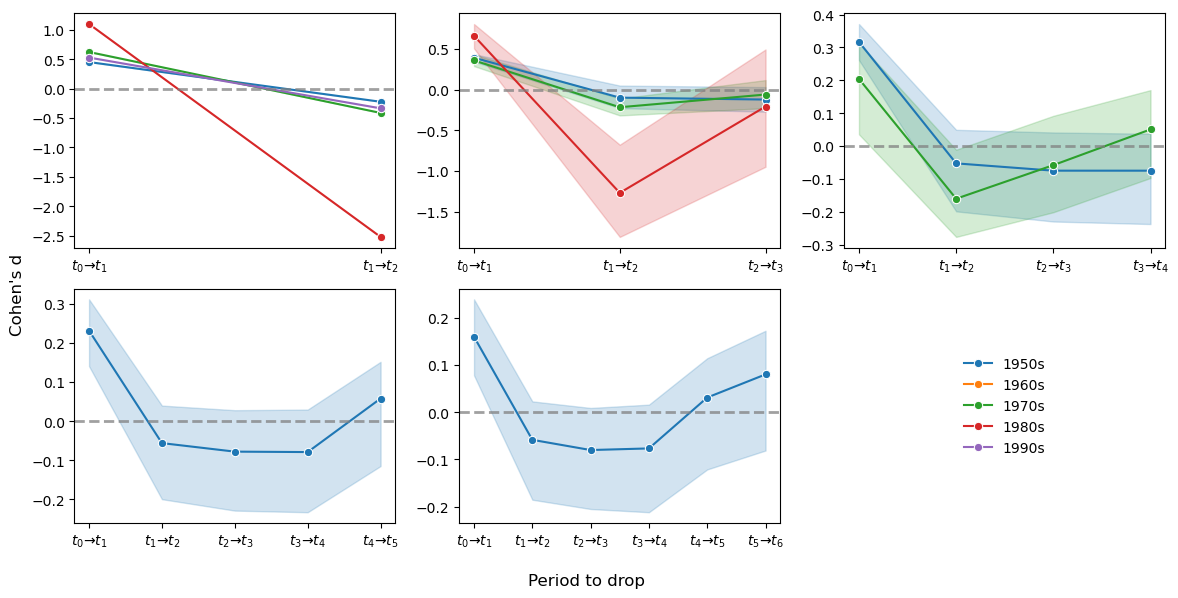

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))

age_groups = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
length_list = [2, 3, 4, 5, 6]

for idx, all_age_group_result_df in enumerate(all_length_result_list):
    length = length_list[idx]
    df_exploded = all_age_group_result_df.explode(list(range(1, length+1)))
    df_long = pd.melt(df_exploded, id_vars=['founded decade'], value_vars=list(range(1, length+1)),
                      var_name='Decades elapsed', value_name='value')

    ax = fig.add_subplot(2,3, idx+1)

    sns.lineplot(data=df_long, x='Decades elapsed', y='value', hue='founded decade', errorbar='pi', marker='o')
    ax.axhline(0, color='grey', alpha=0.75, linestyle='--', lw=2)
    plt.xticks(range(1, length+1), [fr'$t_{num-1}$'+'→'+fr'$t_{num}$' for num in range(1, length+1)])
    plt.xlabel('')
    plt.ylabel('')
    ax.legend().set_visible(False)
    if idx == 0:
        handles, labels = ax.get_legend_handles_labels()

if handles and labels:
    ax = fig.add_subplot(2, 3, 6)
    ax.set_axis_off()
    ax.legend(handles=handles, labels=labels, loc='center',
              frameon=False)

fig.supxlabel('Period to drop')
fig.supylabel('Cohen\'s d')

plt.tight_layout()
plt.show()

# Relation with publication volumn

In [49]:
model = p2v.P2V()

2024-11-04 15:19:19 -- start loading Mag_venue_info_df
2024-11-04 15:19:19 -- finish.
2024-11-04 15:19:19 -- start loading labeled_journal_info_df
2024-11-04 15:19:19 -- finish.


In [50]:
df = local_semantic_change_df.merge(model.MAG_venue_info_df[['VenueID', 'PublicationVolume',
                                                             'PublicationVolume_1950s',
                                                             'PublicationVolume_1960s',
                                                             'PublicationVolume_1970s',
                                                             'PublicationVolume_1980s',
                                                             'PublicationVolume_1990s',
                                                             'PublicationVolume_2000s',
                                                             'PublicationVolume_2010s',
                                                             ]], left_on='VID', right_on='VenueID')

In [51]:
df[['PublicationVolume',
    'PublicationVolume_1950s',
   'PublicationVolume_1960s',
   'PublicationVolume_1970s',
   'PublicationVolume_1980s',
   'PublicationVolume_1990s',
   'PublicationVolume_2000s',
   'PublicationVolume_2010s']] = np.log10(df[['PublicationVolume',
                                              'PublicationVolume_1950s', 
                                              'PublicationVolume_1960s', 
                                              'PublicationVolume_1970s',
                                              'PublicationVolume_1980s',
                                              'PublicationVolume_1990s',
                                              'PublicationVolume_2000s',
                                              'PublicationVolume_2010s']].replace(0, 1e-10))


In [52]:
df

VID  semantic_change_1960s  total_semantic_change_1960s  \
0      2.785285e+06               0.028464                     0.028464   
1      2.756444e+09               0.028157                     0.028157   
2      1.709670e+08               0.030398                     0.030398   
3      1.241662e+08               0.007862                     0.007862   
4      2.764775e+09               0.004671                     0.004671   
...             ...                    ...                          ...   
24139  2.764439e+09                    NaN                          NaN   
24140  2.898526e+09                    NaN                          NaN   
24141  2.010644e+08                    NaN                          NaN   
24142  1.125908e+08                    NaN                          NaN   
24143  2.764833e+09                    NaN                          NaN   

       semantic_change_1970s  total_semantic_change_1970s  \
0                   0.017985                     0.046449   
1                   0.029099                     0.057256   
2                   0.044556                     0.074954   
3                   0.008346                     0.016208   
4                   0.005047                     0.009718   
...                      ...                          ...   
24139                    NaN                          NaN   
24140                    NaN                          NaN   
24141                    NaN                          NaN   
24142                    NaN                          NaN   
24143                    NaN                          NaN   

       semantic_change_1980s  total_semantic_change_1980s  \
0                   0.002580                     0.049029   
1                   0.016555                     0.073812   
2                   0.023140                     0.098095   
3                   0.005651                     0.021859   
4                   0.006526                     0.016243   
...                      ...                          ...   
24139                    NaN                          NaN   
24140                    NaN                          NaN   
24141                    NaN                          NaN   
24142                    NaN                          NaN   
24143                    NaN                          NaN   

       semantic_change_1990s  total_semantic_change_1990s  \
0                   0.005973                     0.055002   
1                   0.025299                     0.099110   
2                   0.006869                     0.104964   
3                   0.010619                     0.032479   
4                   0.002833                     0.019076   
...                      ...                          ...   
24139                    NaN                          NaN   
24140                    NaN                          NaN   
24141                    NaN                          NaN   
24142                    NaN                          NaN   
24143                    NaN                          NaN   

       semantic_change_2000s  total_semantic_change_2000s  \
0                   0.000816                     0.055818   
1                   0.058427                     0.157537   
2                   0.007796                     0.112760   
3                   0.010537                     0.043016   
4                   0.005002                     0.024078   
...                      ...                          ...   
24139                    NaN                          NaN   
24140                    NaN                          NaN   
24141                    NaN                          NaN   
24142                    NaN                          NaN   
24143                    NaN                          NaN   

       semantic_change_2010s  total_semantic_change_2010s  \
0                   0.005635                     0.061453   
1                   0.114181                     0.271718   


In [60]:
# Melt the semantic_change columns
melted_semantic_change = df.melt(id_vars=['VID', 'venue_name', 'scopus_label', 'nan_in_middle', 'len_of_1', 'start_idx', 'end_idx', 'VenueID', 'PublicationVolume'],
                                 value_vars=['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s'],
                                 var_name='decade', value_name='semantic_change')

# Melt the PublicationVolume columns
melted_publication_volume = df.melt(id_vars=['VID', 'venue_name', 'scopus_label', 'nan_in_middle', 'len_of_1', 'start_idx', 'end_idx', 'VenueID', 'PublicationVolume'],
                                    value_vars=['PublicationVolume_1960s', 'PublicationVolume_1970s', 'PublicationVolume_1980s', 'PublicationVolume_1990s', 'PublicationVolume_2000s', 'PublicationVolume_2010s'],
                                    var_name='decade', value_name='publication_volume')

melted_semantic_change['decade'] = melted_semantic_change['decade'].str.extract('(\d{4}s)')
melted_publication_volume['decade'] = melted_publication_volume['decade'].str.extract('(\d{4}s)')
# Merge the two melted DataFrames on common columns and decade
melted_df = pd.merge(melted_semantic_change, melted_publication_volume, on=['VID', 'venue_name', 'scopus_label', 'nan_in_middle', 'len_of_1', 'start_idx', 'end_idx', 'VenueID', 'PublicationVolume', 'decade'])


# Clean up the decade column to remove the prefix
melted_df['decade'] = melted_df['decade'].str.extract('(\d{4}s)')

# Display the new DataFrame
melted_df = melted_df[['VID', 'venue_name', 'scopus_label', 'semantic_change', 'publication_volume','decade']]
melted_df.head()

VID                                              venue_name  \
0  2.785285e+06                    The Journal of Comparative Neurology   
1  2.756444e+09                           Advances in internal medicine   
2  1.709670e+08                        American Journal of Epidemiology   
3  1.241662e+08  Quarterly Journal of Mechanics and Applied Mathematics   
4  2.764775e+09              Journal of the Geological Society of Japan   

                   scopus_label  semantic_change  publication_volume decade  
0                  Neuroscience         0.028464            2.781037  1960s  
1                           NaN         0.028157            1.740363  1960s  
2                      Medicine         0.030398            2.955688  1960s  
3                   Mathematics         0.007862            2.550228  1960s  
4  Earth and Planetary Sciences         0.004671            2.810904  1960s

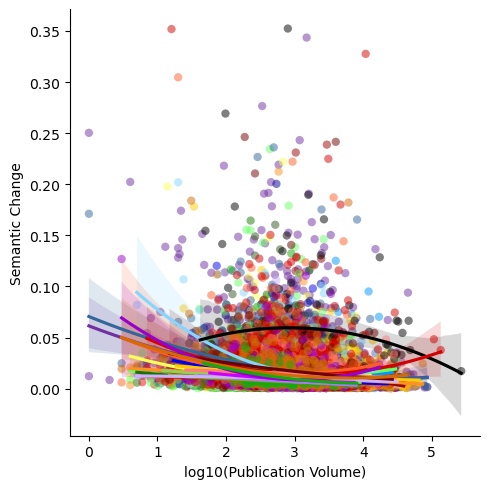

In [131]:
sns.lmplot(data=melted_df, x='publication_volume', y='semantic_change', order=2,
           hue='scopus_label', palette=model.discipline2color, aspect=1, 
           scatter_kws={'alpha': 0.5, 'edgecolor': 'none'}, 
           legend=False)
plt.gca().set_xlabel('log10(Publication Volume)')
plt.gca().set_ylabel('Semantic Change')
plt.show()

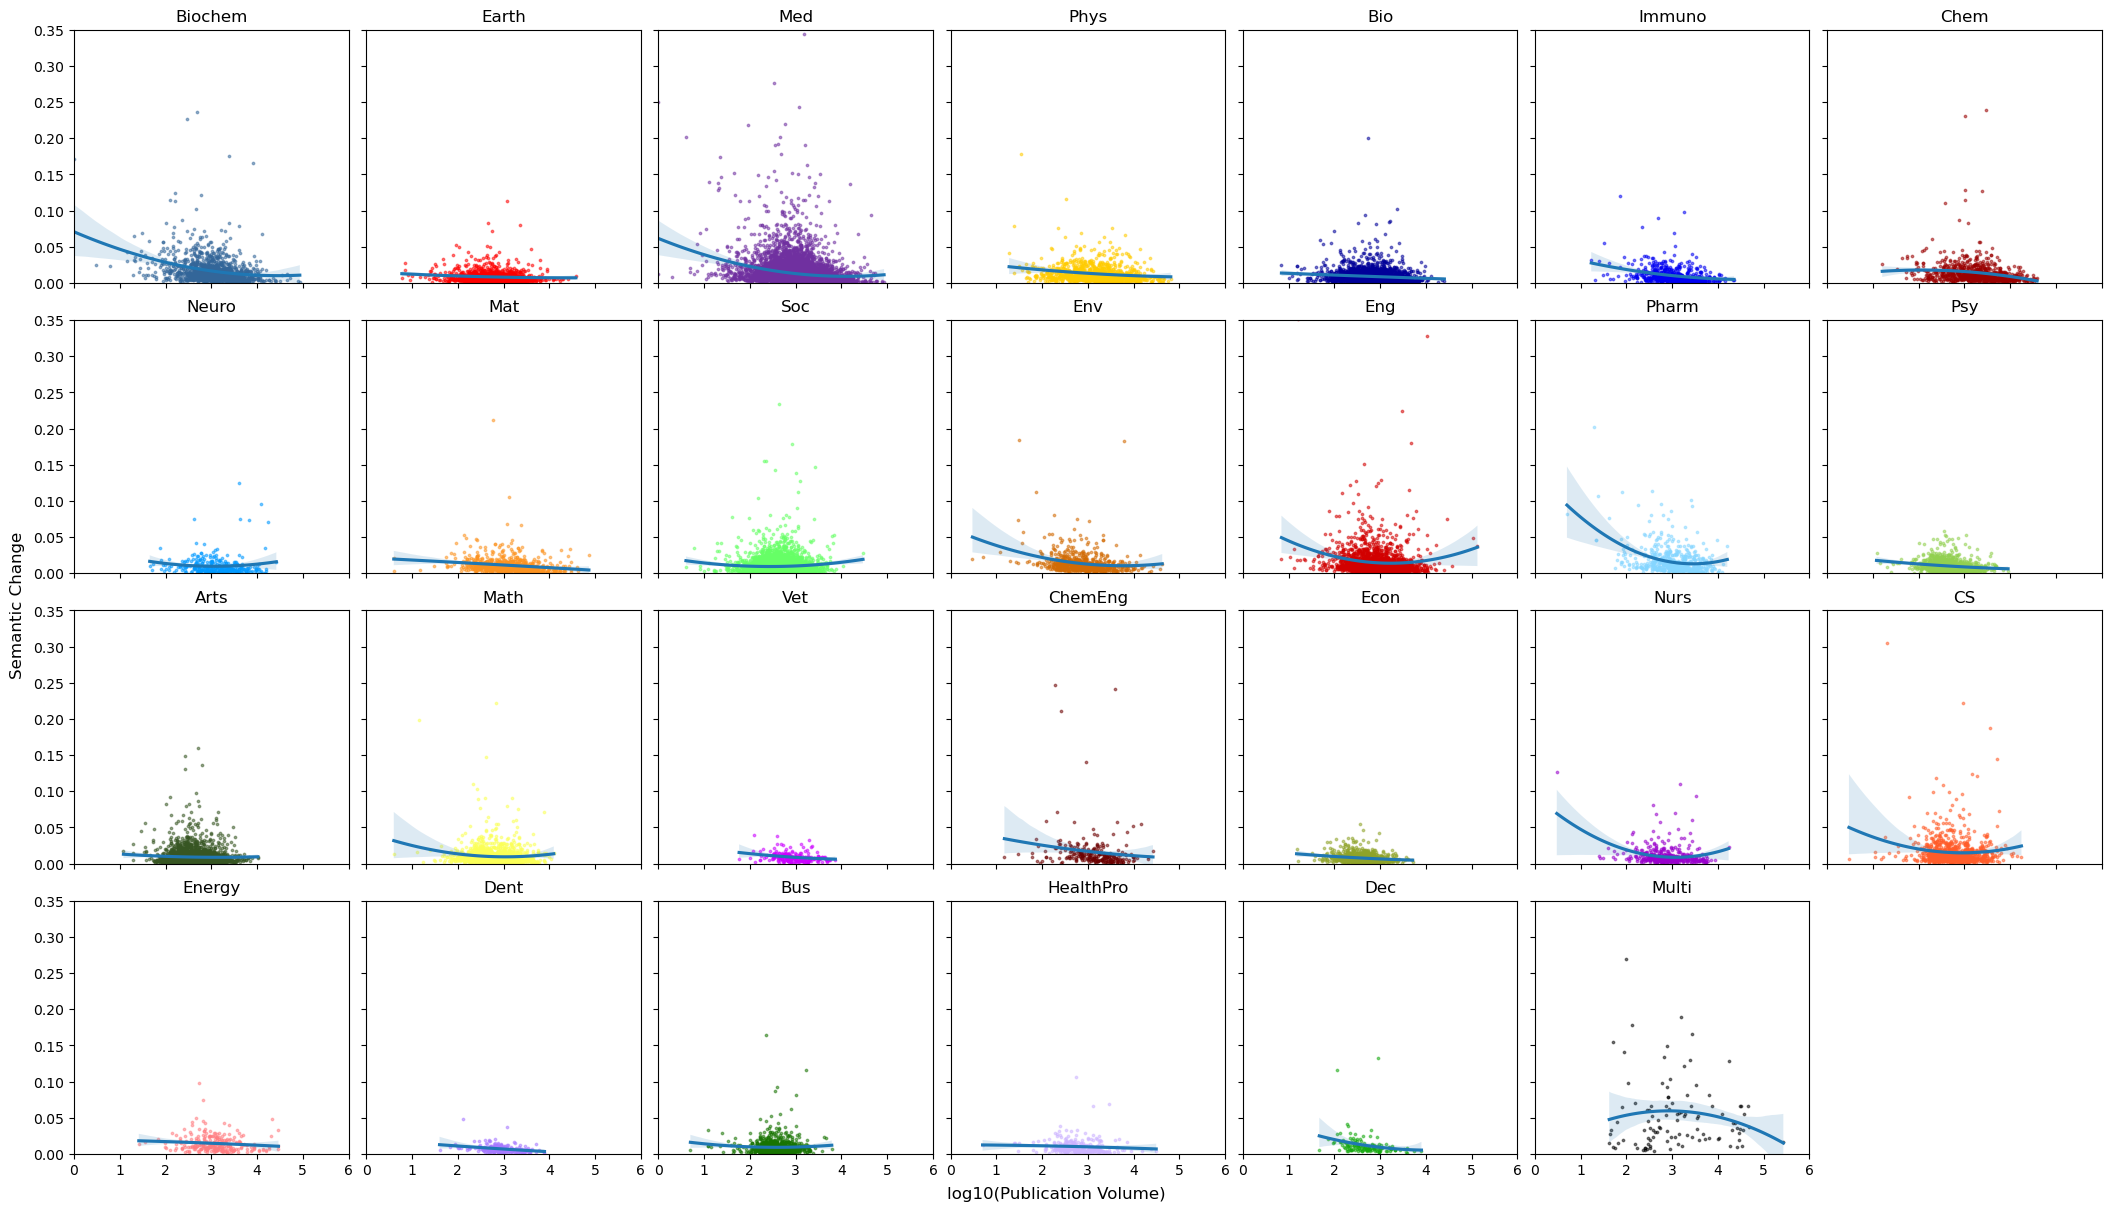

In [133]:
fig = plt.figure(figsize=(21, 12), layout="constrained")
for i, discipline in enumerate(model.disc2abbr.keys()):
    plt.subplot(4, 7, i+1)
    sns.regplot(data=melted_df[melted_df.scopus_label==discipline], x='publication_volume', y='semantic_change', order=2,
                scatter_kws={'s': 3, 'alpha':0.5, 'color': model.discipline2color[discipline]})
    plt.title(model.disc2abbr[discipline])
    plt.gca().set_ylim([0, 0.35])
    plt.gca().set_xlim([0, 6])
    plt.gca().set_xlabel('')
    plt.gca().set_ylabel('')
    if i % 7 != 0:
        plt.gca().set_yticklabels([])
    if i < 21:
        plt.gca().set_xticklabels([])
fig.supxlabel('log10(Publication Volume)')
fig.supylabel('Semantic Change')

plt.show()

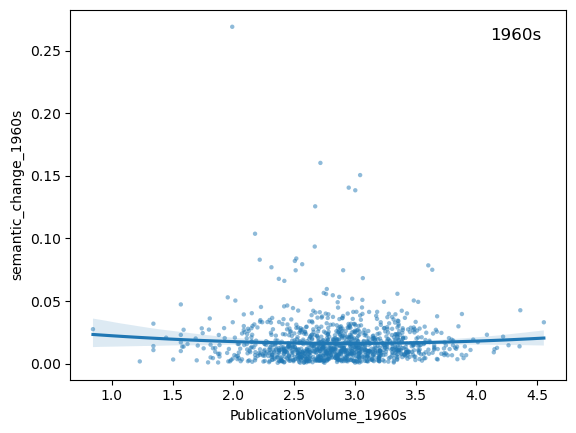

In [46]:
decade = '1960s'
start_idx = 0
tar_df = df[df.start_idx==start_idx]

sns.regplot(tar_df, 
            x='PublicationVolume_'+decade, y='semantic_change_'+decade,
            order=2,
            scatter_kws={'alpha': 0.5, 's': 10, 'edgecolor': 'none'},)
plt.text(0.95, 0.95, f'{decade}', fontsize=12, transform=plt.gca().transAxes, ha='right', va='top')
plt.show()

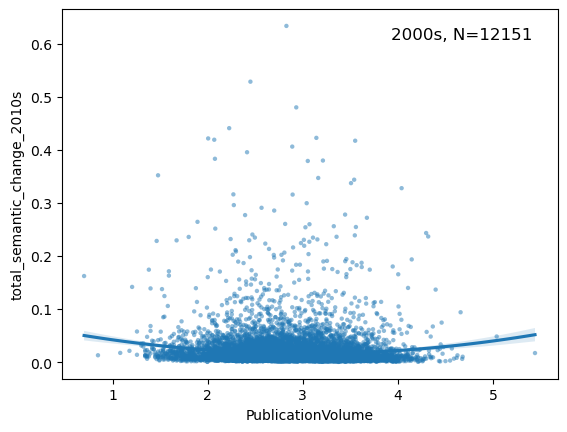

In [29]:
start_idx = 5
tar_df = df[df.start_idx==start_idx]

sns.regplot(tar_df, 
            x='PublicationVolume', y='total_semantic_change_2010s',
            order=2,
            scatter_kws={'alpha': 0.5, 's': 10, 'edgecolor': 'none'},)
plt.text(0.95, 0.95, f'{start_year_list[start_idx]}s, N={len(tar_df)}', fontsize=12, transform=plt.gca().transAxes, ha='right', va='top')
plt.show()

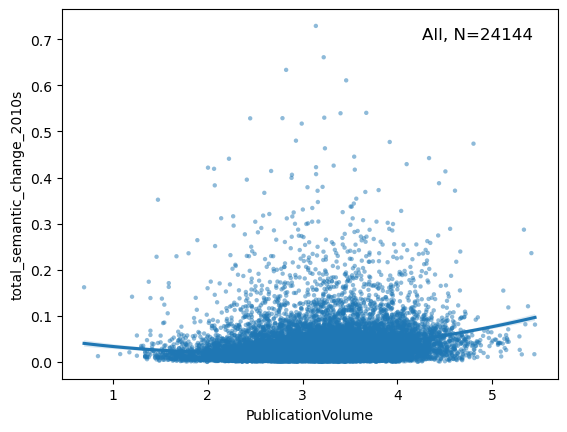

In [30]:
tar_df = df

sns.regplot(tar_df, 
            x='PublicationVolume', y='total_semantic_change_2010s',
            order=2,
            scatter_kws={'alpha': 0.5, 's': 10, 'edgecolor': 'none'},)
plt.text(0.95, 0.95, f'All, N={len(tar_df)}', fontsize=12, transform=plt.gca().transAxes, ha='right', va='top')
plt.show()

# DTW

In [5]:
len(local_semantic_change_df.end_idx - local_semantic_change_df.start_idx >= 1)

24144

In [55]:
sample_size = 2000
# sample_df = local_semantic_change_df[local_semantic_change_df.end_idx - local_semantic_change_df.start_idx >= 1].sample(sample_size)
# sample_df = local_semantic_change_df[local_semantic_change_df.end_idx - local_semantic_change_df.start_idx >= 1]
sample_df = local_semantic_change_df[local_semantic_change_df.start_idx == 0]

time_series = sample_df[['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 
                         'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']].values

time_series = time_series.astype(np.double)
time_series = [ts[~np.isnan(ts)] for ts in time_series]

In [56]:
time_series

[array([0.0284642 , 0.0179848 , 0.00258024, 0.00597256, 0.00081588,
        0.00563491]),
 array([0.02815722, 0.02909912, 0.01655531, 0.02529868, 0.05842669,
        0.11418097]),
 array([0.03039775, 0.04455649, 0.02314036, 0.00686894, 0.00779598,
        0.01070697]),
 array([0.00786176, 0.00834647, 0.00565119, 0.01061937, 0.01053696,
        0.00622213]),
 array([0.00467055, 0.00504697, 0.00652558, 0.00283323, 0.00500153,
        0.00351878]),
 array([0.01149661, 0.01076509, 0.00899856, 0.00654183, 0.01066486,
        0.0039427 ]),
 array([0.02353797, 0.01038024, 0.01456687, 0.01660136, 0.00631667,
        0.00591354]),
 array([0.01709035, 0.01465395, 0.00570457, 0.00647241, 0.00968181,
        0.00440074]),
 array([0.02505152, 0.02423961, 0.00373962, 0.00720202, 0.01216345,
        0.01155804]),
 array([0.00062513, 0.00391423, 0.00597936, 0.00749902, 0.00767557,
        0.00242283]),
 array([0.00419033, 0.0059123 , 0.00468644, 0.00603853, 0.00921499,
        0.00244074]),
 array([0.

In [57]:
from dtaidistance import dtw

distance_matrix = dtw.distance_matrix_fast(time_series)

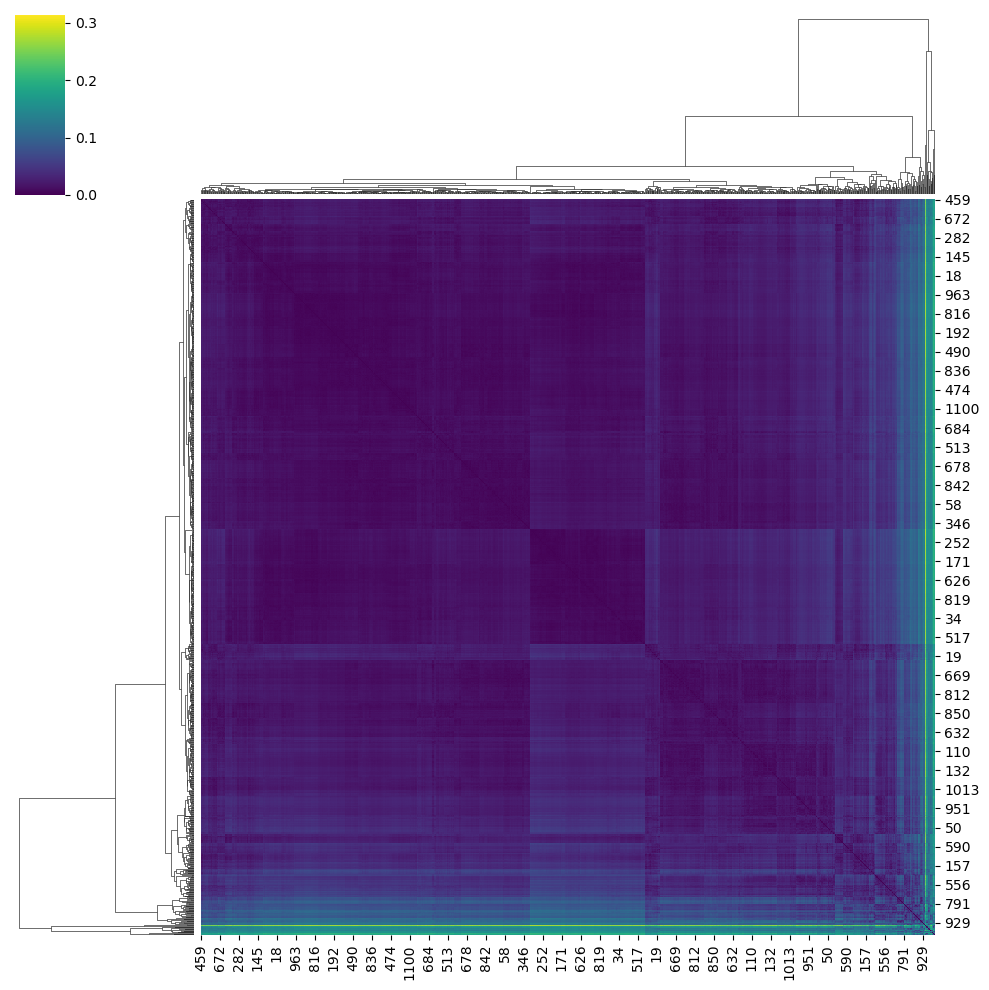

In [58]:
import seaborn as sns

sns.clustermap(distance_matrix, cmap='viridis')

/tmp/ipykernel_97605/2841648689.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distance_matrix, 'single')


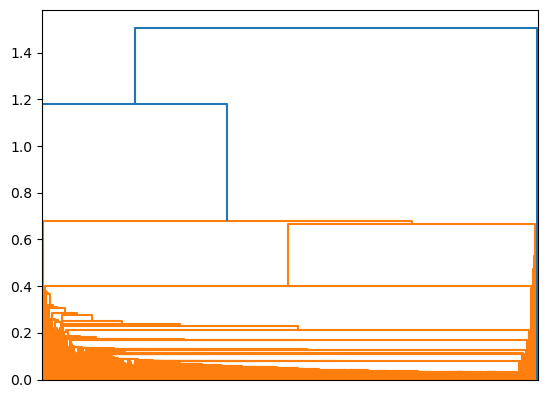

In [60]:
from scipy.cluster import hierarchy

Z = hierarchy.linkage(distance_matrix, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z, no_labels=True)